<a href="https://colab.research.google.com/github/akhilesh1709/Analysis-arena-data-analysis/blob/main/Real_fake_job_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import re
import nltk
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, accuracy_score
from wordcloud import WordCloud
import spacy
import string
import xgboost as xgb
import numpy as np
import plotly.express as px
import plotly.graph_objects as go
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import roc_curve, auc

In [ ]:
df = pd.read_csv("job_train.csv")

In [ ]:
df.head()

,title,location,description,requirements,telecommuting,has_company_logo,has_questions,fraudulent
0,Architect (Middleware - MQ) - Kuwait,"KW, KU,","On behalf of our client, a well known multinat...",-Working technical knowledge of IT systems and...,0,1,0,0
1,Interviewing Now for Sales Rep Positions -- wi...,"US, TX, Corpus Christi","We are Argenta Field Solutions, a rapidly expa...",#NAME?,0,1,0,0
2,Process Controls Staff Engineer - Foxboro I/A ...,"US, TX, USA Southwest",Experienced Process Controls Staff Engineer is...,At least 10 years of degreed professional expe...,0,0,0,0
3,Experienced Telemarketer Wanted - Digital Solu...,"AU, NSW,",If you have a passion for people and love to s...,"Responsibilities - Prospecting, following up a...",0,1,0,0
4,Senior Network Engineer,"GB, ENG, London",As the successful Senior Network Engineer you ...,Essential skills:•Juniper switching/routing/se...,0,1,0,0


In [ ]:
df.describe()

,telecommuting,has_company_logo,has_questions,fraudulent
count,8940.000000,8940.000000,8940.000000,8940.000000
mean,0.043736,0.794407,0.487248,0.051007
std,0.204519,0.404157,0.499865,0.220024
min,0.000000,0.000000,0.000000,0.000000
25%,0.000000,1.000000,0.000000,0.000000
50%,0.000000,1.000000,0.000000,0.000000
75%,0.000000,1.000000,1.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8940 entries, 0 to 8939
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   title             8940 non-null   object
 1   location          8783 non-null   object
 2   description       8939 non-null   object
 3   requirements      7614 non-null   object
 4   telecommuting     8940 non-null   int64 
 5   has_company_logo  8940 non-null   int64 
 6   has_questions     8940 non-null   int64 
 7   fraudulent        8940 non-null   int64 
dtypes: int64(4), object(4)
memory usage: 558.9+ KB


In [ ]:
df.isna().sum()

,0
title,0
location,157
description,1
requirements,1326
telecommuting,0
has_company_logo,0
has_questions,0
fraudulent,0


In [ ]:
df.shape

(8940, 8)

# Handling missing values

In [ ]:
df = df.dropna()

In [ ]:
df.isna().sum()

,0
title,0
location,0
description,0
requirements,0
telecommuting,0
has_company_logo,0
has_questions,0
fraudulent,0


# Exploratory data analysis

To understand the dataset properly, we perform exploratory data analysis

## Distribution of job characteristics

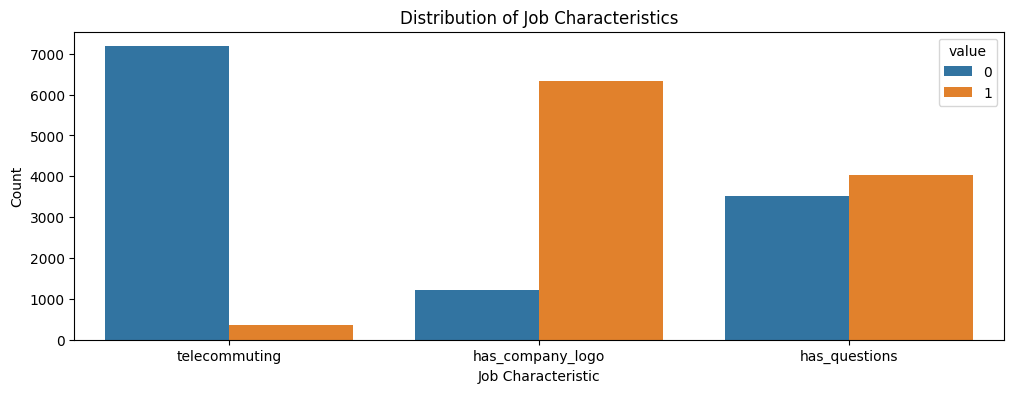

In [ ]:
# Visualize the distribution of telecommuting, company logo, and fraudulent jobs
plt.figure(figsize=(12, 4))
sns.countplot(data=df.melt(value_vars=['telecommuting', 'has_company_logo', 'has_questions']),
              x='variable', hue='value')
plt.title('Distribution of Job Characteristics')
plt.xlabel('Job Characteristic')
plt.ylabel('Count')
plt.show()

## Word cloud of job titles

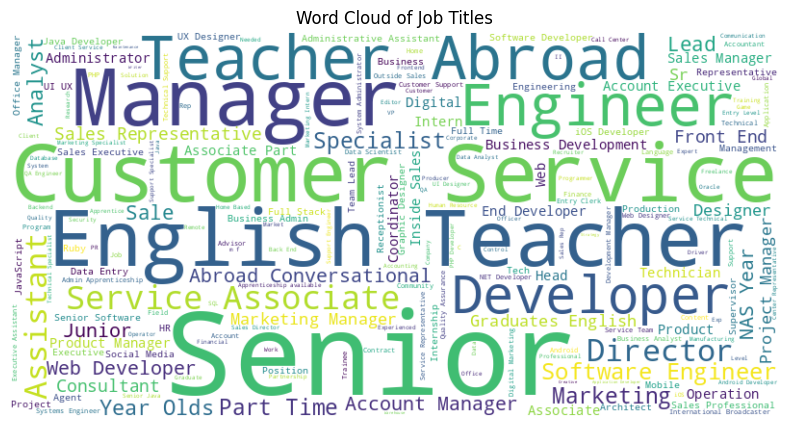

In [ ]:
from wordcloud import WordCloud

wordcloud = WordCloud(width=800, height=400, background_color='white').generate(' '.join(df['title']))
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Job Titles')
plt.show()

## Word cloud of Job requirements

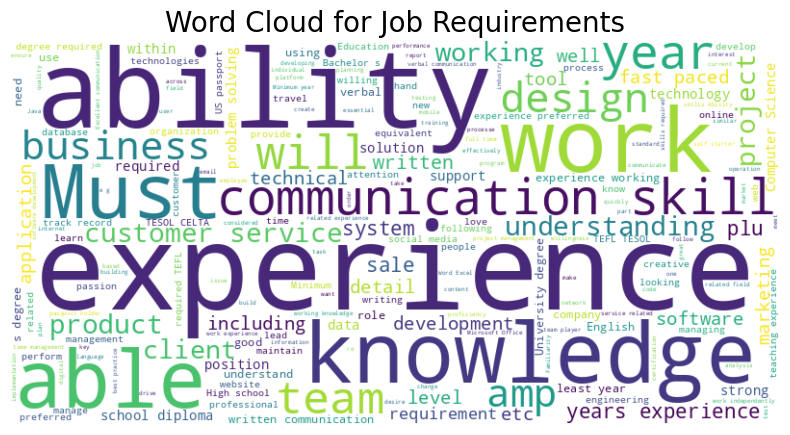

In [ ]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Combine all the text in the 'requirements' column
text = " ".join(requirement for requirement in df['requirements'].dropna())

# Generate the word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white', colormap='viridis').generate(text)

# Plot the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud for Job Requirements', fontsize=20)
plt.show()

## Distribution of Job locations

In [ ]:
# Extract the first part of the location
df['first_part'] = df['location'].str.split(',').str[0].str.strip()

# Count occurrences of each first part
location_counts = df['first_part'].value_counts()

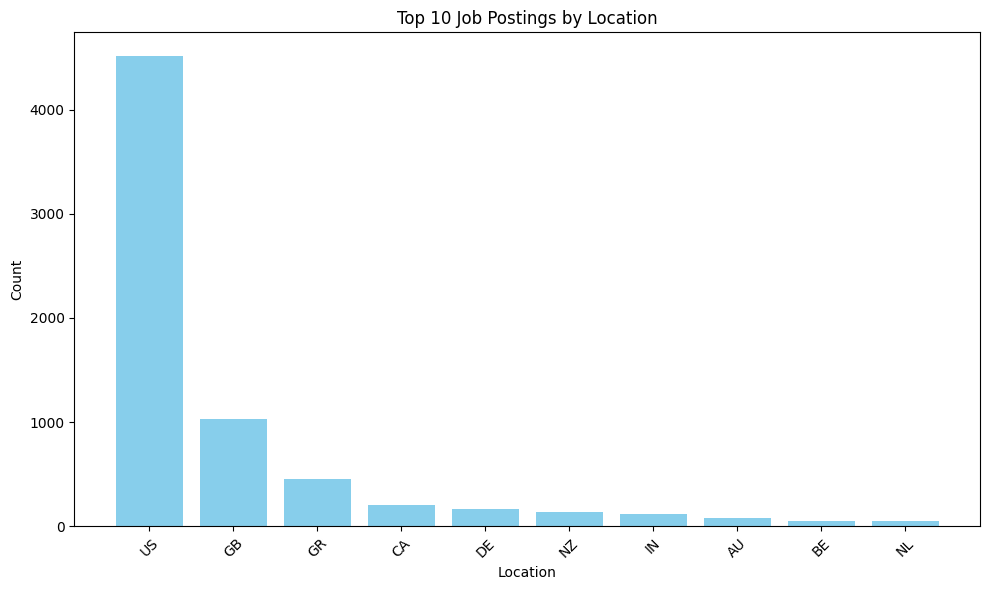

In [ ]:
# Get the top 10 locations
top_10_locations = location_counts.head(10)

# Create a bar plot for the top 10 locations
plt.figure(figsize=(10, 6))
plt.bar(top_10_locations.index, top_10_locations.values, color='skyblue')

# Add labels and title
plt.xlabel('Location')
plt.ylabel('Count')
plt.title('Top 10 Job Postings by Location')

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Show plot
plt.tight_layout()
plt.show()

## Fraudulent and Non-Fraudulent postings

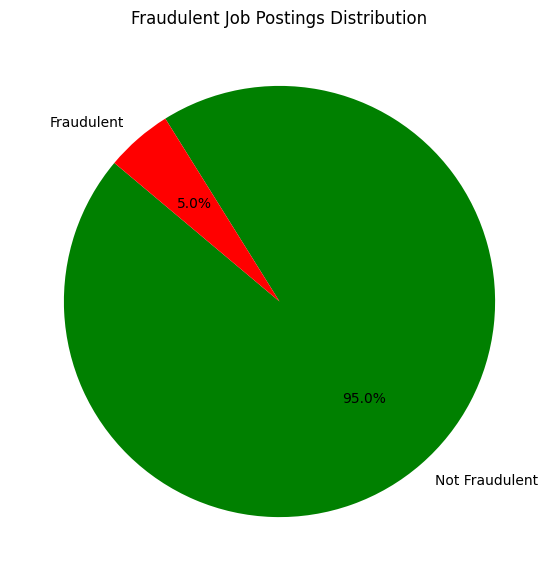

In [ ]:
fraud_counts = df['fraudulent'].value_counts()

# Plot the pie chart
labels = ['Not Fraudulent', 'Fraudulent']
colors = ['green', 'red']

plt.figure(figsize=(7, 7))
plt.pie(fraud_counts, labels=labels, colors=colors, autopct='%1.1f%%', startangle=140)
plt.title('Fraudulent Job Postings Distribution')
plt.show()

## Data Preprocessing

In [ ]:
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [ ]:
df["text"] = df["description"]+df["requirements"]

We apply preprocessing techniques on the dataset to perform cleaning and handling missing values

In [ ]:
def clean_text(text):

    text = text.lower()
    text = re.sub(r'<.*?>', '', text)
    text = re.sub(r'http\S+', '', text)
    text = re.sub(r'[^a-zA-Z0-9]', ' ', text)
    tokens = nltk.word_tokenize(text)
    stop_words = set(nltk.corpus.stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop_words]
    cleaned_text = ' '.join(tokens)

    return cleaned_text

In [ ]:
df['text']=df['text'].apply(clean_text)
df['title']=df['title'].apply(clean_text)

In [ ]:
df["text"]=df["text"].str.lower()
df["title"]=df["title"].str.lower()

In [ ]:
# Create a translation table with all punctuation
translator = str.maketrans('', '', string.punctuation)

# Remove punctuation
df["text"] = df["text"].str.translate(translator)

In [ ]:
# Extract the first part of the location
df['location'] = df['location'].str.split(',').str[0].str.strip()

In [ ]:
# Method 1: Using scikit-learn's LabelEncoder
le = LabelEncoder()

In [ ]:
# Apply label encoding to the 'color' column
df['location'] = le.fit_transform(df['location'])

## Data Normalisation

In [ ]:
nlp = spacy.load("en_core_web_sm")
stemmer = PorterStemmer()

In [ ]:
def normalize_text(text):
    # Tokenize the text
    tokens = word_tokenize(text)

    # Apply stemming
    stemmed_tokens = [stemmer.stem(token) for token in tokens]

    # Join the stemmed tokens back into a single string
    stemmed_text = ' '.join(stemmed_tokens)

    # Apply lemmatization using spaCy
    doc = nlp(stemmed_text)
    lemmatized_words = [token.lemma_ for token in doc]

    # Join the lemmatized words back into a single string
    normalized_text = ' '.join(lemmatized_words)

    return normalized_text

In [ ]:
df['text']=df['text'].apply(normalize_text)

In [ ]:
del df["requirements"]
del df["description"]
del df["first_part"]

# Model training

We use XGBoost classifier to train the model

In [ ]:
  # Feature extraction using TF-IDF
  tfidf = TfidfVectorizer(max_features=5000)
  X = tfidf.fit_transform(df['text']).toarray()
  y = df['fraudulent']

In [ ]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

In [ ]:
# Initialize the XGBoost classifier
xgb_clf = xgb.XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')

# Hyperparameter tuning

We use GridSearchCV to perform Hyperparameter tuning on the XGBoost classifier

In [ ]:
param_grid = {
    'n_estimators': [50, 100, 150],
    'max_depth': [3, 5],
    'learning_rate': [0.01, 0.05, 0.1],
    'subsample': [0.8, 0.9],
    'colsample_bytree': [0.8, 1],
    'gamma': [0, 0.1],
    'reg_alpha': [0, 0.01],
    'reg_lambda': [1, 2],
}

In [ ]:
# Initialize GridSearchCV with the XGBoost classifier and parameter grid
grid_search = GridSearchCV(estimator=xgb_clf, param_grid=param_grid, cv=5, n_jobs=1, verbose=2, scoring='roc_auc')

In [ ]:
# Fit the model
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 576 candidates, totalling 2880 fits


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [18:56:49] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.01, max_depth=3, n_estimators=50, reg_alpha=0, reg_lambda=1, subsample=0.8; total time=  12.5s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [18:57:01] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.01, max_depth=3, n_estimators=50, reg_alpha=0, reg_lambda=1, subsample=0.8; total time=  12.1s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [18:57:12] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.01, max_depth=3, n_estimators=50, reg_alpha=0, reg_lambda=1, subsample=0.8; total time=  11.7s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [18:57:23] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.01, max_depth=3, n_estimators=50, reg_alpha=0, reg_lambda=1, subsample=0.8; total time=  11.7s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [18:57:35] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.01, max_depth=3, n_estimators=50, reg_alpha=0, reg_lambda=1, subsample=0.8; total time=  11.6s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [18:57:47] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.01, max_depth=3, n_estimators=50, reg_alpha=0, reg_lambda=1, subsample=0.9; total time=  11.0s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [18:57:59] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.01, max_depth=3, n_estimators=50, reg_alpha=0, reg_lambda=1, subsample=0.9; total time=  11.5s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [18:58:11] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.01, max_depth=3, n_estimators=50, reg_alpha=0, reg_lambda=1, subsample=0.9; total time=  12.1s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [18:58:22] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.01, max_depth=3, n_estimators=50, reg_alpha=0, reg_lambda=1, subsample=0.9; total time=  11.7s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [18:58:33] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.01, max_depth=3, n_estimators=50, reg_alpha=0, reg_lambda=1, subsample=0.9; total time=  11.8s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [18:58:45] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.01, max_depth=3, n_estimators=50, reg_alpha=0, reg_lambda=2, subsample=0.8; total time=  11.7s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [18:58:57] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.01, max_depth=3, n_estimators=50, reg_alpha=0, reg_lambda=2, subsample=0.8; total time=  11.6s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [18:59:10] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.01, max_depth=3, n_estimators=50, reg_alpha=0, reg_lambda=2, subsample=0.8; total time=  13.0s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [18:59:22] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.01, max_depth=3, n_estimators=50, reg_alpha=0, reg_lambda=2, subsample=0.8; total time=  11.2s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [18:59:34] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.01, max_depth=3, n_estimators=50, reg_alpha=0, reg_lambda=2, subsample=0.8; total time=  12.1s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [18:59:45] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.01, max_depth=3, n_estimators=50, reg_alpha=0, reg_lambda=2, subsample=0.9; total time=  11.7s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [18:59:56] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.01, max_depth=3, n_estimators=50, reg_alpha=0, reg_lambda=2, subsample=0.9; total time=  11.7s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [19:00:08] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.01, max_depth=3, n_estimators=50, reg_alpha=0, reg_lambda=2, subsample=0.9; total time=  11.6s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [19:00:20] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.01, max_depth=3, n_estimators=50, reg_alpha=0, reg_lambda=2, subsample=0.9; total time=  11.3s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [19:00:32] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.01, max_depth=3, n_estimators=50, reg_alpha=0, reg_lambda=2, subsample=0.9; total time=  11.0s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [19:00:44] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.01, max_depth=3, n_estimators=50, reg_alpha=0.01, reg_lambda=1, subsample=0.8; total time=  12.2s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [19:00:55] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.01, max_depth=3, n_estimators=50, reg_alpha=0.01, reg_lambda=1, subsample=0.8; total time=  11.8s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [19:01:06] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.01, max_depth=3, n_estimators=50, reg_alpha=0.01, reg_lambda=1, subsample=0.8; total time=  11.4s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [19:01:17] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.01, max_depth=3, n_estimators=50, reg_alpha=0.01, reg_lambda=1, subsample=0.8; total time=  11.6s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [19:01:29] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.01, max_depth=3, n_estimators=50, reg_alpha=0.01, reg_lambda=1, subsample=0.8; total time=  11.5s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [19:01:41] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.01, max_depth=3, n_estimators=50, reg_alpha=0.01, reg_lambda=1, subsample=0.9; total time=  10.7s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [19:01:53] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.01, max_depth=3, n_estimators=50, reg_alpha=0.01, reg_lambda=1, subsample=0.9; total time=  12.0s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [19:02:04] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.01, max_depth=3, n_estimators=50, reg_alpha=0.01, reg_lambda=1, subsample=0.9; total time=  11.7s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [19:02:15] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.01, max_depth=3, n_estimators=50, reg_alpha=0.01, reg_lambda=1, subsample=0.9; total time=  11.5s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [19:02:27] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.01, max_depth=3, n_estimators=50, reg_alpha=0.01, reg_lambda=1, subsample=0.9; total time=  11.5s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [19:02:38] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.01, max_depth=3, n_estimators=50, reg_alpha=0.01, reg_lambda=2, subsample=0.8; total time=  12.6s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [19:02:51] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.01, max_depth=3, n_estimators=50, reg_alpha=0.01, reg_lambda=2, subsample=0.8; total time=  10.9s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [19:03:03] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.01, max_depth=3, n_estimators=50, reg_alpha=0.01, reg_lambda=2, subsample=0.8; total time=  11.6s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [19:03:15] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.01, max_depth=3, n_estimators=50, reg_alpha=0.01, reg_lambda=2, subsample=0.8; total time=  12.1s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [19:03:25] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.01, max_depth=3, n_estimators=50, reg_alpha=0.01, reg_lambda=2, subsample=0.8; total time=  11.6s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [19:03:37] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.01, max_depth=3, n_estimators=50, reg_alpha=0.01, reg_lambda=2, subsample=0.9; total time=  11.6s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [19:03:48] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.01, max_depth=3, n_estimators=50, reg_alpha=0.01, reg_lambda=2, subsample=0.9; total time=  11.4s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [19:04:00] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.01, max_depth=3, n_estimators=50, reg_alpha=0.01, reg_lambda=2, subsample=0.9; total time=  11.1s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [19:04:12] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.01, max_depth=3, n_estimators=50, reg_alpha=0.01, reg_lambda=2, subsample=0.9; total time=  11.4s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [19:04:24] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.01, max_depth=3, n_estimators=50, reg_alpha=0.01, reg_lambda=2, subsample=0.9; total time=  12.1s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [19:04:35] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.01, max_depth=3, n_estimators=100, reg_alpha=0, reg_lambda=1, subsample=0.8; total time=  20.1s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [19:04:55] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.01, max_depth=3, n_estimators=100, reg_alpha=0, reg_lambda=1, subsample=0.8; total time=  19.3s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [19:05:14] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.01, max_depth=3, n_estimators=100, reg_alpha=0, reg_lambda=1, subsample=0.8; total time=  19.7s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [19:05:35] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.01, max_depth=3, n_estimators=100, reg_alpha=0, reg_lambda=1, subsample=0.8; total time=  20.1s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [19:05:54] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.01, max_depth=3, n_estimators=100, reg_alpha=0, reg_lambda=1, subsample=0.8; total time=  19.4s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [19:06:14] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.01, max_depth=3, n_estimators=100, reg_alpha=0, reg_lambda=1, subsample=0.9; total time=  21.5s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [19:06:34] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.01, max_depth=3, n_estimators=100, reg_alpha=0, reg_lambda=1, subsample=0.9; total time=  18.5s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [19:06:53] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.01, max_depth=3, n_estimators=100, reg_alpha=0, reg_lambda=1, subsample=0.9; total time=  20.1s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [19:07:13] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.01, max_depth=3, n_estimators=100, reg_alpha=0, reg_lambda=1, subsample=0.9; total time=  19.0s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [19:07:32] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.01, max_depth=3, n_estimators=100, reg_alpha=0, reg_lambda=1, subsample=0.9; total time=  19.7s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [19:07:53] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.01, max_depth=3, n_estimators=100, reg_alpha=0, reg_lambda=2, subsample=0.8; total time=  19.8s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [19:08:12] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.01, max_depth=3, n_estimators=100, reg_alpha=0, reg_lambda=2, subsample=0.8; total time=  19.2s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [19:08:33] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.01, max_depth=3, n_estimators=100, reg_alpha=0, reg_lambda=2, subsample=0.8; total time=  21.0s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [19:08:52] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.01, max_depth=3, n_estimators=100, reg_alpha=0, reg_lambda=2, subsample=0.8; total time=  19.3s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [19:09:12] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.01, max_depth=3, n_estimators=100, reg_alpha=0, reg_lambda=2, subsample=0.8; total time=  20.3s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [19:09:31] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.01, max_depth=3, n_estimators=100, reg_alpha=0, reg_lambda=2, subsample=0.9; total time=  19.8s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [19:09:51] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.01, max_depth=3, n_estimators=100, reg_alpha=0, reg_lambda=2, subsample=0.9; total time=  19.9s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [19:10:11] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.01, max_depth=3, n_estimators=100, reg_alpha=0, reg_lambda=2, subsample=0.9; total time=  19.2s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [19:10:30] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.01, max_depth=3, n_estimators=100, reg_alpha=0, reg_lambda=2, subsample=0.9; total time=  19.3s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [19:10:51] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.01, max_depth=3, n_estimators=100, reg_alpha=0, reg_lambda=2, subsample=0.9; total time=  21.0s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [19:11:11] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.01, max_depth=3, n_estimators=100, reg_alpha=0.01, reg_lambda=1, subsample=0.8; total time=  19.7s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [19:11:31] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.01, max_depth=3, n_estimators=100, reg_alpha=0.01, reg_lambda=1, subsample=0.8; total time=  20.7s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [19:11:51] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.01, max_depth=3, n_estimators=100, reg_alpha=0.01, reg_lambda=1, subsample=0.8; total time=  19.4s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [19:12:10] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.01, max_depth=3, n_estimators=100, reg_alpha=0.01, reg_lambda=1, subsample=0.8; total time=  19.5s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [19:12:30] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.01, max_depth=3, n_estimators=100, reg_alpha=0.01, reg_lambda=1, subsample=0.8; total time=  19.0s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [19:12:49] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.01, max_depth=3, n_estimators=100, reg_alpha=0.01, reg_lambda=1, subsample=0.9; total time=  18.5s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [19:13:08] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.01, max_depth=3, n_estimators=100, reg_alpha=0.01, reg_lambda=1, subsample=0.9; total time=  20.0s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [19:13:27] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.01, max_depth=3, n_estimators=100, reg_alpha=0.01, reg_lambda=1, subsample=0.9; total time=  19.1s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [19:13:47] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.01, max_depth=3, n_estimators=100, reg_alpha=0.01, reg_lambda=1, subsample=0.9; total time=  20.1s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [19:14:07] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.01, max_depth=3, n_estimators=100, reg_alpha=0.01, reg_lambda=1, subsample=0.9; total time=  21.3s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [19:14:28] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.01, max_depth=3, n_estimators=100, reg_alpha=0.01, reg_lambda=2, subsample=0.8; total time=  19.5s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [19:14:49] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.01, max_depth=3, n_estimators=100, reg_alpha=0.01, reg_lambda=2, subsample=0.8; total time=  20.9s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [19:15:08] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.01, max_depth=3, n_estimators=100, reg_alpha=0.01, reg_lambda=2, subsample=0.8; total time=  19.1s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [19:15:27] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.01, max_depth=3, n_estimators=100, reg_alpha=0.01, reg_lambda=2, subsample=0.8; total time=  19.9s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [19:15:47] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.01, max_depth=3, n_estimators=100, reg_alpha=0.01, reg_lambda=2, subsample=0.8; total time=  18.7s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [19:16:06] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.01, max_depth=3, n_estimators=100, reg_alpha=0.01, reg_lambda=2, subsample=0.9; total time=  18.7s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [19:16:25] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.01, max_depth=3, n_estimators=100, reg_alpha=0.01, reg_lambda=2, subsample=0.9; total time=  19.9s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [19:16:44] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.01, max_depth=3, n_estimators=100, reg_alpha=0.01, reg_lambda=2, subsample=0.9; total time=  18.4s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [19:17:03] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.01, max_depth=3, n_estimators=100, reg_alpha=0.01, reg_lambda=2, subsample=0.9; total time=  18.3s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [19:17:23] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.01, max_depth=3, n_estimators=100, reg_alpha=0.01, reg_lambda=2, subsample=0.9; total time=  20.5s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [19:17:42] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.01, max_depth=3, n_estimators=150, reg_alpha=0, reg_lambda=1, subsample=0.8; total time=  29.4s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [19:18:11] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.01, max_depth=3, n_estimators=150, reg_alpha=0, reg_lambda=1, subsample=0.8; total time=  27.5s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [19:18:38] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.01, max_depth=3, n_estimators=150, reg_alpha=0, reg_lambda=1, subsample=0.8; total time=  27.3s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [19:19:06] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.01, max_depth=3, n_estimators=150, reg_alpha=0, reg_lambda=1, subsample=0.8; total time=  27.5s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [19:19:33] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.01, max_depth=3, n_estimators=150, reg_alpha=0, reg_lambda=1, subsample=0.8; total time=  27.2s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [19:20:00] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.01, max_depth=3, n_estimators=150, reg_alpha=0, reg_lambda=1, subsample=0.9; total time=  27.7s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [19:20:28] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.01, max_depth=3, n_estimators=150, reg_alpha=0, reg_lambda=1, subsample=0.9; total time=  28.3s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [19:20:57] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.01, max_depth=3, n_estimators=150, reg_alpha=0, reg_lambda=1, subsample=0.9; total time=  29.3s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [19:21:26] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.01, max_depth=3, n_estimators=150, reg_alpha=0, reg_lambda=1, subsample=0.9; total time=  28.1s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [19:21:54] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.01, max_depth=3, n_estimators=150, reg_alpha=0, reg_lambda=1, subsample=0.9; total time=  28.0s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [19:22:22] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.01, max_depth=3, n_estimators=150, reg_alpha=0, reg_lambda=2, subsample=0.8; total time=  27.7s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [19:22:50] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.01, max_depth=3, n_estimators=150, reg_alpha=0, reg_lambda=2, subsample=0.8; total time=  28.2s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [19:23:18] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.01, max_depth=3, n_estimators=150, reg_alpha=0, reg_lambda=2, subsample=0.8; total time=  28.2s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [19:23:47] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.01, max_depth=3, n_estimators=150, reg_alpha=0, reg_lambda=2, subsample=0.8; total time=  28.2s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [19:24:16] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.01, max_depth=3, n_estimators=150, reg_alpha=0, reg_lambda=2, subsample=0.8; total time=  29.6s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [19:24:45] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.01, max_depth=3, n_estimators=150, reg_alpha=0, reg_lambda=2, subsample=0.9; total time=  29.1s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [19:25:15] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.01, max_depth=3, n_estimators=150, reg_alpha=0, reg_lambda=2, subsample=0.9; total time=  29.8s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [19:25:44] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.01, max_depth=3, n_estimators=150, reg_alpha=0, reg_lambda=2, subsample=0.9; total time=  28.8s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [19:26:12] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.01, max_depth=3, n_estimators=150, reg_alpha=0, reg_lambda=2, subsample=0.9; total time=  28.3s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [19:26:40] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.01, max_depth=3, n_estimators=150, reg_alpha=0, reg_lambda=2, subsample=0.9; total time=  27.8s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [19:27:08] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.01, max_depth=3, n_estimators=150, reg_alpha=0.01, reg_lambda=1, subsample=0.8; total time=  27.6s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [19:27:35] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.01, max_depth=3, n_estimators=150, reg_alpha=0.01, reg_lambda=1, subsample=0.8; total time=  28.5s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [19:28:04] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.01, max_depth=3, n_estimators=150, reg_alpha=0.01, reg_lambda=1, subsample=0.8; total time=  27.7s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [19:28:32] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.01, max_depth=3, n_estimators=150, reg_alpha=0.01, reg_lambda=1, subsample=0.8; total time=  27.6s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [19:29:00] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.01, max_depth=3, n_estimators=150, reg_alpha=0.01, reg_lambda=1, subsample=0.8; total time=  27.9s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [19:29:28] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.01, max_depth=3, n_estimators=150, reg_alpha=0.01, reg_lambda=1, subsample=0.9; total time=  28.5s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [19:29:56] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.01, max_depth=3, n_estimators=150, reg_alpha=0.01, reg_lambda=1, subsample=0.9; total time=  28.6s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [19:30:25] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.01, max_depth=3, n_estimators=150, reg_alpha=0.01, reg_lambda=1, subsample=0.9; total time=  28.1s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [19:30:53] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.01, max_depth=3, n_estimators=150, reg_alpha=0.01, reg_lambda=1, subsample=0.9; total time=  29.5s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [19:31:22] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.01, max_depth=3, n_estimators=150, reg_alpha=0.01, reg_lambda=1, subsample=0.9; total time=  27.2s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [19:31:49] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.01, max_depth=3, n_estimators=150, reg_alpha=0.01, reg_lambda=2, subsample=0.8; total time=  27.5s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [19:32:16] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.01, max_depth=3, n_estimators=150, reg_alpha=0.01, reg_lambda=2, subsample=0.8; total time=  31.0s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [19:32:50] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.01, max_depth=3, n_estimators=150, reg_alpha=0.01, reg_lambda=2, subsample=0.8; total time=  28.9s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [19:33:18] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.01, max_depth=3, n_estimators=150, reg_alpha=0.01, reg_lambda=2, subsample=0.8; total time=  28.7s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [19:33:46] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.01, max_depth=3, n_estimators=150, reg_alpha=0.01, reg_lambda=2, subsample=0.8; total time=  28.4s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [19:34:14] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.01, max_depth=3, n_estimators=150, reg_alpha=0.01, reg_lambda=2, subsample=0.9; total time=  30.2s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [19:34:45] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.01, max_depth=3, n_estimators=150, reg_alpha=0.01, reg_lambda=2, subsample=0.9; total time=  29.0s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [19:35:14] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.01, max_depth=3, n_estimators=150, reg_alpha=0.01, reg_lambda=2, subsample=0.9; total time=  28.1s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [19:35:41] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.01, max_depth=3, n_estimators=150, reg_alpha=0.01, reg_lambda=2, subsample=0.9; total time=  27.4s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [19:36:08] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.01, max_depth=3, n_estimators=150, reg_alpha=0.01, reg_lambda=2, subsample=0.9; total time=  27.4s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [19:36:36] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.01, max_depth=5, n_estimators=50, reg_alpha=0, reg_lambda=1, subsample=0.8; total time=  13.0s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [19:36:49] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.01, max_depth=5, n_estimators=50, reg_alpha=0, reg_lambda=1, subsample=0.8; total time=  13.4s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [19:37:03] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.01, max_depth=5, n_estimators=50, reg_alpha=0, reg_lambda=1, subsample=0.8; total time=  13.0s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [19:37:16] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.01, max_depth=5, n_estimators=50, reg_alpha=0, reg_lambda=1, subsample=0.8; total time=  13.1s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [19:37:30] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.01, max_depth=5, n_estimators=50, reg_alpha=0, reg_lambda=1, subsample=0.8; total time=  13.1s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [19:37:43] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.01, max_depth=5, n_estimators=50, reg_alpha=0, reg_lambda=1, subsample=0.9; total time=  15.0s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [19:37:58] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.01, max_depth=5, n_estimators=50, reg_alpha=0, reg_lambda=1, subsample=0.9; total time=  13.5s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [19:38:11] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.01, max_depth=5, n_estimators=50, reg_alpha=0, reg_lambda=1, subsample=0.9; total time=  12.7s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [19:38:24] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.01, max_depth=5, n_estimators=50, reg_alpha=0, reg_lambda=1, subsample=0.9; total time=  12.5s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [19:38:36] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.01, max_depth=5, n_estimators=50, reg_alpha=0, reg_lambda=1, subsample=0.9; total time=  12.5s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [19:38:48] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.01, max_depth=5, n_estimators=50, reg_alpha=0, reg_lambda=2, subsample=0.8; total time=  12.4s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [19:39:00] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.01, max_depth=5, n_estimators=50, reg_alpha=0, reg_lambda=2, subsample=0.8; total time=  13.0s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [19:39:14] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.01, max_depth=5, n_estimators=50, reg_alpha=0, reg_lambda=2, subsample=0.8; total time=  13.3s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [19:39:27] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.01, max_depth=5, n_estimators=50, reg_alpha=0, reg_lambda=2, subsample=0.8; total time=  13.1s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [19:39:40] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.01, max_depth=5, n_estimators=50, reg_alpha=0, reg_lambda=2, subsample=0.8; total time=  12.9s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [19:39:53] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.01, max_depth=5, n_estimators=50, reg_alpha=0, reg_lambda=2, subsample=0.9; total time=  13.2s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [19:40:06] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.01, max_depth=5, n_estimators=50, reg_alpha=0, reg_lambda=2, subsample=0.9; total time=  12.6s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [19:40:18] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.01, max_depth=5, n_estimators=50, reg_alpha=0, reg_lambda=2, subsample=0.9; total time=  12.3s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [19:40:31] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.01, max_depth=5, n_estimators=50, reg_alpha=0, reg_lambda=2, subsample=0.9; total time=  11.8s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [19:40:44] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.01, max_depth=5, n_estimators=50, reg_alpha=0, reg_lambda=2, subsample=0.9; total time=  13.1s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [19:40:57] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.01, max_depth=5, n_estimators=50, reg_alpha=0.01, reg_lambda=1, subsample=0.8; total time=  15.0s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [19:41:12] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.01, max_depth=5, n_estimators=50, reg_alpha=0.01, reg_lambda=1, subsample=0.8; total time=  13.5s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [19:41:26] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.01, max_depth=5, n_estimators=50, reg_alpha=0.01, reg_lambda=1, subsample=0.8; total time=  13.3s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [19:41:39] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.01, max_depth=5, n_estimators=50, reg_alpha=0.01, reg_lambda=1, subsample=0.8; total time=  13.3s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [19:41:53] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.01, max_depth=5, n_estimators=50, reg_alpha=0.01, reg_lambda=1, subsample=0.8; total time=  13.5s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [19:42:06] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.01, max_depth=5, n_estimators=50, reg_alpha=0.01, reg_lambda=1, subsample=0.9; total time=  13.7s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [19:42:19] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.01, max_depth=5, n_estimators=50, reg_alpha=0.01, reg_lambda=1, subsample=0.9; total time=  13.0s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [19:42:31] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.01, max_depth=5, n_estimators=50, reg_alpha=0.01, reg_lambda=1, subsample=0.9; total time=  12.3s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [19:42:43] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.01, max_depth=5, n_estimators=50, reg_alpha=0.01, reg_lambda=1, subsample=0.9; total time=  12.4s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [19:42:56] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.01, max_depth=5, n_estimators=50, reg_alpha=0.01, reg_lambda=1, subsample=0.9; total time=  12.9s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [19:43:09] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.01, max_depth=5, n_estimators=50, reg_alpha=0.01, reg_lambda=2, subsample=0.8; total time=  13.1s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [19:43:22] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.01, max_depth=5, n_estimators=50, reg_alpha=0.01, reg_lambda=2, subsample=0.8; total time=  13.4s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [19:43:35] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.01, max_depth=5, n_estimators=50, reg_alpha=0.01, reg_lambda=2, subsample=0.8; total time=  13.2s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [19:43:49] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.01, max_depth=5, n_estimators=50, reg_alpha=0.01, reg_lambda=2, subsample=0.8; total time=  13.2s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [19:44:02] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.01, max_depth=5, n_estimators=50, reg_alpha=0.01, reg_lambda=2, subsample=0.8; total time=  13.0s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [19:44:15] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.01, max_depth=5, n_estimators=50, reg_alpha=0.01, reg_lambda=2, subsample=0.9; total time=  14.5s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [19:44:29] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.01, max_depth=5, n_estimators=50, reg_alpha=0.01, reg_lambda=2, subsample=0.9; total time=  12.3s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [19:44:41] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.01, max_depth=5, n_estimators=50, reg_alpha=0.01, reg_lambda=2, subsample=0.9; total time=  12.0s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [19:44:54] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.01, max_depth=5, n_estimators=50, reg_alpha=0.01, reg_lambda=2, subsample=0.9; total time=  12.3s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [19:45:07] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.01, max_depth=5, n_estimators=50, reg_alpha=0.01, reg_lambda=2, subsample=0.9; total time=  13.5s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [19:45:21] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.01, max_depth=5, n_estimators=100, reg_alpha=0, reg_lambda=1, subsample=0.8; total time=  24.0s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [19:45:44] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.01, max_depth=5, n_estimators=100, reg_alpha=0, reg_lambda=1, subsample=0.8; total time=  24.2s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [19:46:08] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.01, max_depth=5, n_estimators=100, reg_alpha=0, reg_lambda=1, subsample=0.8; total time=  23.8s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [19:46:32] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.01, max_depth=5, n_estimators=100, reg_alpha=0, reg_lambda=1, subsample=0.8; total time=  23.6s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [19:46:56] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.01, max_depth=5, n_estimators=100, reg_alpha=0, reg_lambda=1, subsample=0.8; total time=  24.0s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [19:47:19] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.01, max_depth=5, n_estimators=100, reg_alpha=0, reg_lambda=1, subsample=0.9; total time=  24.8s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [19:47:45] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.01, max_depth=5, n_estimators=100, reg_alpha=0, reg_lambda=1, subsample=0.9; total time=  23.7s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [19:48:07] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.01, max_depth=5, n_estimators=100, reg_alpha=0, reg_lambda=1, subsample=0.9; total time=  23.2s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [19:48:30] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.01, max_depth=5, n_estimators=100, reg_alpha=0, reg_lambda=1, subsample=0.9; total time=  22.3s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [19:48:54] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.01, max_depth=5, n_estimators=100, reg_alpha=0, reg_lambda=1, subsample=0.9; total time=  23.7s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [19:49:17] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.01, max_depth=5, n_estimators=100, reg_alpha=0, reg_lambda=2, subsample=0.8; total time=  23.7s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [19:49:41] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.01, max_depth=5, n_estimators=100, reg_alpha=0, reg_lambda=2, subsample=0.8; total time=  24.1s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [19:50:05] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.01, max_depth=5, n_estimators=100, reg_alpha=0, reg_lambda=2, subsample=0.8; total time=  23.4s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [19:50:29] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.01, max_depth=5, n_estimators=100, reg_alpha=0, reg_lambda=2, subsample=0.8; total time=  24.1s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [19:50:53] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.01, max_depth=5, n_estimators=100, reg_alpha=0, reg_lambda=2, subsample=0.8; total time=  25.0s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [19:51:17] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.01, max_depth=5, n_estimators=100, reg_alpha=0, reg_lambda=2, subsample=0.9; total time=  23.2s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [19:51:41] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.01, max_depth=5, n_estimators=100, reg_alpha=0, reg_lambda=2, subsample=0.9; total time=  23.7s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [19:52:04] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.01, max_depth=5, n_estimators=100, reg_alpha=0, reg_lambda=2, subsample=0.9; total time=  23.4s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [19:52:27] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.01, max_depth=5, n_estimators=100, reg_alpha=0, reg_lambda=2, subsample=0.9; total time=  23.7s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [19:52:52] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.01, max_depth=5, n_estimators=100, reg_alpha=0, reg_lambda=2, subsample=0.9; total time=  23.3s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [19:53:15] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.01, max_depth=5, n_estimators=100, reg_alpha=0.01, reg_lambda=1, subsample=0.8; total time=  23.7s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [19:53:38] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.01, max_depth=5, n_estimators=100, reg_alpha=0.01, reg_lambda=1, subsample=0.8; total time=  24.3s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [19:54:03] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.01, max_depth=5, n_estimators=100, reg_alpha=0.01, reg_lambda=1, subsample=0.8; total time=  24.3s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [19:54:28] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.01, max_depth=5, n_estimators=100, reg_alpha=0.01, reg_lambda=1, subsample=0.8; total time=  24.3s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [19:54:51] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.01, max_depth=5, n_estimators=100, reg_alpha=0.01, reg_lambda=1, subsample=0.8; total time=  23.7s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [19:55:15] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.01, max_depth=5, n_estimators=100, reg_alpha=0.01, reg_lambda=1, subsample=0.9; total time=  23.7s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [19:55:39] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.01, max_depth=5, n_estimators=100, reg_alpha=0.01, reg_lambda=1, subsample=0.9; total time=  22.8s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [19:56:01] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.01, max_depth=5, n_estimators=100, reg_alpha=0.01, reg_lambda=1, subsample=0.9; total time=  23.4s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [19:56:25] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.01, max_depth=5, n_estimators=100, reg_alpha=0.01, reg_lambda=1, subsample=0.9; total time=  24.0s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [19:56:49] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.01, max_depth=5, n_estimators=100, reg_alpha=0.01, reg_lambda=1, subsample=0.9; total time=  22.8s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [19:57:12] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.01, max_depth=5, n_estimators=100, reg_alpha=0.01, reg_lambda=2, subsample=0.8; total time=  25.0s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [19:57:37] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.01, max_depth=5, n_estimators=100, reg_alpha=0.01, reg_lambda=2, subsample=0.8; total time=  24.3s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [19:58:01] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.01, max_depth=5, n_estimators=100, reg_alpha=0.01, reg_lambda=2, subsample=0.8; total time=  23.5s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [19:58:25] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.01, max_depth=5, n_estimators=100, reg_alpha=0.01, reg_lambda=2, subsample=0.8; total time=  23.6s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [19:58:48] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.01, max_depth=5, n_estimators=100, reg_alpha=0.01, reg_lambda=2, subsample=0.8; total time=  22.7s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [19:59:10] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.01, max_depth=5, n_estimators=100, reg_alpha=0.01, reg_lambda=2, subsample=0.9; total time=  22.1s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [19:59:34] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.01, max_depth=5, n_estimators=100, reg_alpha=0.01, reg_lambda=2, subsample=0.9; total time=  23.6s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [19:59:56] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.01, max_depth=5, n_estimators=100, reg_alpha=0.01, reg_lambda=2, subsample=0.9; total time=  24.1s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [20:00:21] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.01, max_depth=5, n_estimators=100, reg_alpha=0.01, reg_lambda=2, subsample=0.9; total time=  25.2s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [20:00:46] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.01, max_depth=5, n_estimators=100, reg_alpha=0.01, reg_lambda=2, subsample=0.9; total time=  22.7s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [20:01:09] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.01, max_depth=5, n_estimators=150, reg_alpha=0, reg_lambda=1, subsample=0.8; total time=  36.4s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [20:01:45] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.01, max_depth=5, n_estimators=150, reg_alpha=0, reg_lambda=1, subsample=0.8; total time=  35.4s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [20:02:22] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.01, max_depth=5, n_estimators=150, reg_alpha=0, reg_lambda=1, subsample=0.8; total time=  36.5s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [20:02:57] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.01, max_depth=5, n_estimators=150, reg_alpha=0, reg_lambda=1, subsample=0.8; total time=  36.1s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [20:03:32] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.01, max_depth=5, n_estimators=150, reg_alpha=0, reg_lambda=1, subsample=0.8; total time=  34.3s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [20:04:07] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.01, max_depth=5, n_estimators=150, reg_alpha=0, reg_lambda=1, subsample=0.9; total time=  34.6s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [20:04:43] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.01, max_depth=5, n_estimators=150, reg_alpha=0, reg_lambda=1, subsample=0.9; total time=  36.8s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [20:05:19] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.01, max_depth=5, n_estimators=150, reg_alpha=0, reg_lambda=1, subsample=0.9; total time=  36.4s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [20:05:55] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.01, max_depth=5, n_estimators=150, reg_alpha=0, reg_lambda=1, subsample=0.9; total time=  35.1s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [20:06:31] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.01, max_depth=5, n_estimators=150, reg_alpha=0, reg_lambda=1, subsample=0.9; total time=  37.2s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [20:07:07] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.01, max_depth=5, n_estimators=150, reg_alpha=0, reg_lambda=2, subsample=0.8; total time=  35.9s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [20:07:44] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.01, max_depth=5, n_estimators=150, reg_alpha=0, reg_lambda=2, subsample=0.8; total time=  36.2s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [20:08:19] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.01, max_depth=5, n_estimators=150, reg_alpha=0, reg_lambda=2, subsample=0.8; total time=  35.2s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [20:08:54] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.01, max_depth=5, n_estimators=150, reg_alpha=0, reg_lambda=2, subsample=0.8; total time=  33.3s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [20:09:27] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.01, max_depth=5, n_estimators=150, reg_alpha=0, reg_lambda=2, subsample=0.8; total time=  34.5s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [20:10:03] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.01, max_depth=5, n_estimators=150, reg_alpha=0, reg_lambda=2, subsample=0.9; total time=  36.0s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [20:10:38] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.01, max_depth=5, n_estimators=150, reg_alpha=0, reg_lambda=2, subsample=0.9; total time=  37.2s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [20:11:16] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.01, max_depth=5, n_estimators=150, reg_alpha=0, reg_lambda=2, subsample=0.9; total time=  35.4s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [20:11:53] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.01, max_depth=5, n_estimators=150, reg_alpha=0, reg_lambda=2, subsample=0.9; total time=  36.5s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [20:12:28] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.01, max_depth=5, n_estimators=150, reg_alpha=0, reg_lambda=2, subsample=0.9; total time=  35.0s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [20:13:04] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.01, max_depth=5, n_estimators=150, reg_alpha=0.01, reg_lambda=1, subsample=0.8; total time=  37.2s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [20:13:40] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.01, max_depth=5, n_estimators=150, reg_alpha=0.01, reg_lambda=1, subsample=0.8; total time=  36.6s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [20:14:16] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.01, max_depth=5, n_estimators=150, reg_alpha=0.01, reg_lambda=1, subsample=0.8; total time=  33.8s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [20:14:49] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.01, max_depth=5, n_estimators=150, reg_alpha=0.01, reg_lambda=1, subsample=0.8; total time=  34.2s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [20:15:24] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.01, max_depth=5, n_estimators=150, reg_alpha=0.01, reg_lambda=1, subsample=0.8; total time=  32.8s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [20:15:57] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.01, max_depth=5, n_estimators=150, reg_alpha=0.01, reg_lambda=1, subsample=0.9; total time=  37.6s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [20:16:35] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.01, max_depth=5, n_estimators=150, reg_alpha=0.01, reg_lambda=1, subsample=0.9; total time=  36.4s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [20:17:13] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.01, max_depth=5, n_estimators=150, reg_alpha=0.01, reg_lambda=1, subsample=0.9; total time=  36.8s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [20:17:48] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.01, max_depth=5, n_estimators=150, reg_alpha=0.01, reg_lambda=1, subsample=0.9; total time=  36.3s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [20:18:24] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.01, max_depth=5, n_estimators=150, reg_alpha=0.01, reg_lambda=1, subsample=0.9; total time=  34.8s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [20:18:59] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.01, max_depth=5, n_estimators=150, reg_alpha=0.01, reg_lambda=2, subsample=0.8; total time=  37.7s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [20:19:37] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.01, max_depth=5, n_estimators=150, reg_alpha=0.01, reg_lambda=2, subsample=0.8; total time=  35.5s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [20:20:12] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.01, max_depth=5, n_estimators=150, reg_alpha=0.01, reg_lambda=2, subsample=0.8; total time=  35.5s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [20:20:47] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.01, max_depth=5, n_estimators=150, reg_alpha=0.01, reg_lambda=2, subsample=0.8; total time=  33.1s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [20:21:20] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.01, max_depth=5, n_estimators=150, reg_alpha=0.01, reg_lambda=2, subsample=0.8; total time=  33.9s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [20:21:54] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.01, max_depth=5, n_estimators=150, reg_alpha=0.01, reg_lambda=2, subsample=0.9; total time=  36.5s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [20:22:31] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.01, max_depth=5, n_estimators=150, reg_alpha=0.01, reg_lambda=2, subsample=0.9; total time=  37.3s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [20:23:09] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.01, max_depth=5, n_estimators=150, reg_alpha=0.01, reg_lambda=2, subsample=0.9; total time=  35.7s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [20:23:46] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.01, max_depth=5, n_estimators=150, reg_alpha=0.01, reg_lambda=2, subsample=0.9; total time=  36.3s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [20:24:20] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.01, max_depth=5, n_estimators=150, reg_alpha=0.01, reg_lambda=2, subsample=0.9; total time=  35.0s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [20:24:56] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.05, max_depth=3, n_estimators=50, reg_alpha=0, reg_lambda=1, subsample=0.8; total time=  11.4s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [20:25:09] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.05, max_depth=3, n_estimators=50, reg_alpha=0, reg_lambda=1, subsample=0.8; total time=  12.5s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [20:25:20] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.05, max_depth=3, n_estimators=50, reg_alpha=0, reg_lambda=1, subsample=0.8; total time=  12.9s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [20:25:32] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.05, max_depth=3, n_estimators=50, reg_alpha=0, reg_lambda=1, subsample=0.8; total time=  11.3s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [20:25:43] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.05, max_depth=3, n_estimators=50, reg_alpha=0, reg_lambda=1, subsample=0.8; total time=  10.9s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [20:25:54] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.05, max_depth=3, n_estimators=50, reg_alpha=0, reg_lambda=1, subsample=0.9; total time=  10.4s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [20:26:06] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.05, max_depth=3, n_estimators=50, reg_alpha=0, reg_lambda=1, subsample=0.9; total time=  12.0s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [20:26:17] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.05, max_depth=3, n_estimators=50, reg_alpha=0, reg_lambda=1, subsample=0.9; total time=  12.0s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [20:26:29] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.05, max_depth=3, n_estimators=50, reg_alpha=0, reg_lambda=1, subsample=0.9; total time=  12.0s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [20:26:41] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.05, max_depth=3, n_estimators=50, reg_alpha=0, reg_lambda=1, subsample=0.9; total time=  12.2s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [20:26:53] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.05, max_depth=3, n_estimators=50, reg_alpha=0, reg_lambda=2, subsample=0.8; total time=  12.1s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [20:27:05] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.05, max_depth=3, n_estimators=50, reg_alpha=0, reg_lambda=2, subsample=0.8; total time=  11.3s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [20:27:17] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.05, max_depth=3, n_estimators=50, reg_alpha=0, reg_lambda=2, subsample=0.8; total time=  11.3s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [20:27:28] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.05, max_depth=3, n_estimators=50, reg_alpha=0, reg_lambda=2, subsample=0.8; total time=  11.6s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [20:27:39] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.05, max_depth=3, n_estimators=50, reg_alpha=0, reg_lambda=2, subsample=0.8; total time=  11.2s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [20:27:50] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.05, max_depth=3, n_estimators=50, reg_alpha=0, reg_lambda=2, subsample=0.9; total time=  11.3s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [20:28:02] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.05, max_depth=3, n_estimators=50, reg_alpha=0, reg_lambda=2, subsample=0.9; total time=  11.7s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [20:28:14] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.05, max_depth=3, n_estimators=50, reg_alpha=0, reg_lambda=2, subsample=0.9; total time=  11.9s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [20:28:28] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.05, max_depth=3, n_estimators=50, reg_alpha=0, reg_lambda=2, subsample=0.9; total time=  13.2s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [20:28:39] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.05, max_depth=3, n_estimators=50, reg_alpha=0, reg_lambda=2, subsample=0.9; total time=  12.0s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [20:28:51] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.05, max_depth=3, n_estimators=50, reg_alpha=0.01, reg_lambda=1, subsample=0.8; total time=  11.9s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [20:29:03] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.05, max_depth=3, n_estimators=50, reg_alpha=0.01, reg_lambda=1, subsample=0.8; total time=  12.0s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [20:29:14] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.05, max_depth=3, n_estimators=50, reg_alpha=0.01, reg_lambda=1, subsample=0.8; total time=  11.3s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [20:29:25] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.05, max_depth=3, n_estimators=50, reg_alpha=0.01, reg_lambda=1, subsample=0.8; total time=  10.4s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [20:29:37] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.05, max_depth=3, n_estimators=50, reg_alpha=0.01, reg_lambda=1, subsample=0.8; total time=  11.4s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [20:29:47] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.05, max_depth=3, n_estimators=50, reg_alpha=0.01, reg_lambda=1, subsample=0.9; total time=  11.3s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [20:29:59] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.05, max_depth=3, n_estimators=50, reg_alpha=0.01, reg_lambda=1, subsample=0.9; total time=  11.8s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [20:30:11] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.05, max_depth=3, n_estimators=50, reg_alpha=0.01, reg_lambda=1, subsample=0.9; total time=  12.0s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [20:30:23] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.05, max_depth=3, n_estimators=50, reg_alpha=0.01, reg_lambda=1, subsample=0.9; total time=  11.8s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [20:30:35] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.05, max_depth=3, n_estimators=50, reg_alpha=0.01, reg_lambda=1, subsample=0.9; total time=  11.1s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [20:30:47] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.05, max_depth=3, n_estimators=50, reg_alpha=0.01, reg_lambda=2, subsample=0.8; total time=  12.4s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [20:30:59] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.05, max_depth=3, n_estimators=50, reg_alpha=0.01, reg_lambda=2, subsample=0.8; total time=  11.7s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [20:31:09] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.05, max_depth=3, n_estimators=50, reg_alpha=0.01, reg_lambda=2, subsample=0.8; total time=  11.3s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [20:31:21] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.05, max_depth=3, n_estimators=50, reg_alpha=0.01, reg_lambda=2, subsample=0.8; total time=  12.8s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [20:31:33] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.05, max_depth=3, n_estimators=50, reg_alpha=0.01, reg_lambda=2, subsample=0.8; total time=  10.7s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [20:31:45] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.05, max_depth=3, n_estimators=50, reg_alpha=0.01, reg_lambda=2, subsample=0.9; total time=  11.4s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [20:31:58] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.05, max_depth=3, n_estimators=50, reg_alpha=0.01, reg_lambda=2, subsample=0.9; total time=  12.6s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [20:32:10] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.05, max_depth=3, n_estimators=50, reg_alpha=0.01, reg_lambda=2, subsample=0.9; total time=  12.2s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [20:32:21] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.05, max_depth=3, n_estimators=50, reg_alpha=0.01, reg_lambda=2, subsample=0.9; total time=  12.1s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [20:32:33] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.05, max_depth=3, n_estimators=50, reg_alpha=0.01, reg_lambda=2, subsample=0.9; total time=  11.9s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [20:32:45] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.05, max_depth=3, n_estimators=100, reg_alpha=0, reg_lambda=1, subsample=0.8; total time=  21.0s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [20:33:07] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.05, max_depth=3, n_estimators=100, reg_alpha=0, reg_lambda=1, subsample=0.8; total time=  21.9s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [20:33:28] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.05, max_depth=3, n_estimators=100, reg_alpha=0, reg_lambda=1, subsample=0.8; total time=  19.9s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [20:33:49] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.05, max_depth=3, n_estimators=100, reg_alpha=0, reg_lambda=1, subsample=0.8; total time=  21.2s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [20:34:08] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.05, max_depth=3, n_estimators=100, reg_alpha=0, reg_lambda=1, subsample=0.8; total time=  20.9s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [20:34:30] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.05, max_depth=3, n_estimators=100, reg_alpha=0, reg_lambda=1, subsample=0.9; total time=  21.2s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [20:34:51] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.05, max_depth=3, n_estimators=100, reg_alpha=0, reg_lambda=1, subsample=0.9; total time=  21.6s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [20:35:13] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.05, max_depth=3, n_estimators=100, reg_alpha=0, reg_lambda=1, subsample=0.9; total time=  21.3s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [20:35:34] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.05, max_depth=3, n_estimators=100, reg_alpha=0, reg_lambda=1, subsample=0.9; total time=  21.9s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [20:35:56] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.05, max_depth=3, n_estimators=100, reg_alpha=0, reg_lambda=1, subsample=0.9; total time=  20.6s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [20:36:17] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.05, max_depth=3, n_estimators=100, reg_alpha=0, reg_lambda=2, subsample=0.8; total time=  22.2s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [20:36:38] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.05, max_depth=3, n_estimators=100, reg_alpha=0, reg_lambda=2, subsample=0.8; total time=  20.5s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [20:37:00] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.05, max_depth=3, n_estimators=100, reg_alpha=0, reg_lambda=2, subsample=0.8; total time=  21.3s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [20:37:20] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.05, max_depth=3, n_estimators=100, reg_alpha=0, reg_lambda=2, subsample=0.8; total time=  21.3s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [20:37:42] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.05, max_depth=3, n_estimators=100, reg_alpha=0, reg_lambda=2, subsample=0.8; total time=  21.1s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [20:38:02] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.05, max_depth=3, n_estimators=100, reg_alpha=0, reg_lambda=2, subsample=0.9; total time=  20.2s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [20:38:24] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.05, max_depth=3, n_estimators=100, reg_alpha=0, reg_lambda=2, subsample=0.9; total time=  22.5s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [20:38:46] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.05, max_depth=3, n_estimators=100, reg_alpha=0, reg_lambda=2, subsample=0.9; total time=  21.7s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [20:39:08] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.05, max_depth=3, n_estimators=100, reg_alpha=0, reg_lambda=2, subsample=0.9; total time=  21.7s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [20:39:29] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.05, max_depth=3, n_estimators=100, reg_alpha=0, reg_lambda=2, subsample=0.9; total time=  21.6s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [20:39:51] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.05, max_depth=3, n_estimators=100, reg_alpha=0.01, reg_lambda=1, subsample=0.8; total time=  20.8s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [20:40:11] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.05, max_depth=3, n_estimators=100, reg_alpha=0.01, reg_lambda=1, subsample=0.8; total time=  22.2s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [20:40:33] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.05, max_depth=3, n_estimators=100, reg_alpha=0.01, reg_lambda=1, subsample=0.8; total time=  19.8s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [20:40:53] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.05, max_depth=3, n_estimators=100, reg_alpha=0.01, reg_lambda=1, subsample=0.8; total time=  20.8s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [20:41:14] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.05, max_depth=3, n_estimators=100, reg_alpha=0.01, reg_lambda=1, subsample=0.8; total time=  19.4s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [20:41:33] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.05, max_depth=3, n_estimators=100, reg_alpha=0.01, reg_lambda=1, subsample=0.9; total time=  22.1s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [20:41:56] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.05, max_depth=3, n_estimators=100, reg_alpha=0.01, reg_lambda=1, subsample=0.9; total time=  21.0s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [20:42:18] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.05, max_depth=3, n_estimators=100, reg_alpha=0.01, reg_lambda=1, subsample=0.9; total time=  22.2s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [20:42:39] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.05, max_depth=3, n_estimators=100, reg_alpha=0.01, reg_lambda=1, subsample=0.9; total time=  21.1s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [20:43:01] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.05, max_depth=3, n_estimators=100, reg_alpha=0.01, reg_lambda=1, subsample=0.9; total time=  22.4s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [20:43:23] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.05, max_depth=3, n_estimators=100, reg_alpha=0.01, reg_lambda=2, subsample=0.8; total time=  23.0s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [20:43:45] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.05, max_depth=3, n_estimators=100, reg_alpha=0.01, reg_lambda=2, subsample=0.8; total time=  20.3s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [20:44:05] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.05, max_depth=3, n_estimators=100, reg_alpha=0.01, reg_lambda=2, subsample=0.8; total time=  21.2s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [20:44:26] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.05, max_depth=3, n_estimators=100, reg_alpha=0.01, reg_lambda=2, subsample=0.8; total time=  19.9s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [20:44:46] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.05, max_depth=3, n_estimators=100, reg_alpha=0.01, reg_lambda=2, subsample=0.8; total time=  20.9s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [20:45:08] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.05, max_depth=3, n_estimators=100, reg_alpha=0.01, reg_lambda=2, subsample=0.9; total time=  21.4s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [20:45:30] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.05, max_depth=3, n_estimators=100, reg_alpha=0.01, reg_lambda=2, subsample=0.9; total time=  22.2s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [20:45:51] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.05, max_depth=3, n_estimators=100, reg_alpha=0.01, reg_lambda=2, subsample=0.9; total time=  21.2s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [20:46:14] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.05, max_depth=3, n_estimators=100, reg_alpha=0.01, reg_lambda=2, subsample=0.9; total time=  23.7s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [20:46:36] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.05, max_depth=3, n_estimators=100, reg_alpha=0.01, reg_lambda=2, subsample=0.9; total time=  21.8s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [20:46:58] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.05, max_depth=3, n_estimators=150, reg_alpha=0, reg_lambda=1, subsample=0.8; total time=  30.0s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [20:47:28] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.05, max_depth=3, n_estimators=150, reg_alpha=0, reg_lambda=1, subsample=0.8; total time=  29.2s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [20:47:57] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.05, max_depth=3, n_estimators=150, reg_alpha=0, reg_lambda=1, subsample=0.8; total time=  29.4s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [20:48:26] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.05, max_depth=3, n_estimators=150, reg_alpha=0, reg_lambda=1, subsample=0.8; total time=  29.0s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [20:48:55] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.05, max_depth=3, n_estimators=150, reg_alpha=0, reg_lambda=1, subsample=0.8; total time=  30.5s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [20:49:26] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.05, max_depth=3, n_estimators=150, reg_alpha=0, reg_lambda=1, subsample=0.9; total time=  32.0s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [20:49:59] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.05, max_depth=3, n_estimators=150, reg_alpha=0, reg_lambda=1, subsample=0.9; total time=  31.1s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [20:50:29] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.05, max_depth=3, n_estimators=150, reg_alpha=0, reg_lambda=1, subsample=0.9; total time=  30.4s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [20:51:00] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.05, max_depth=3, n_estimators=150, reg_alpha=0, reg_lambda=1, subsample=0.9; total time=  30.3s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [20:51:30] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.05, max_depth=3, n_estimators=150, reg_alpha=0, reg_lambda=1, subsample=0.9; total time=  30.3s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [20:52:01] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.05, max_depth=3, n_estimators=150, reg_alpha=0, reg_lambda=2, subsample=0.8; total time=  33.0s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [20:52:33] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.05, max_depth=3, n_estimators=150, reg_alpha=0, reg_lambda=2, subsample=0.8; total time=  29.6s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [20:53:02] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.05, max_depth=3, n_estimators=150, reg_alpha=0, reg_lambda=2, subsample=0.8; total time=  30.0s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [20:53:32] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.05, max_depth=3, n_estimators=150, reg_alpha=0, reg_lambda=2, subsample=0.8; total time=  29.3s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [20:54:01] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.05, max_depth=3, n_estimators=150, reg_alpha=0, reg_lambda=2, subsample=0.8; total time=  29.4s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [20:54:32] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.05, max_depth=3, n_estimators=150, reg_alpha=0, reg_lambda=2, subsample=0.9; total time=  33.8s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [20:55:05] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.05, max_depth=3, n_estimators=150, reg_alpha=0, reg_lambda=2, subsample=0.9; total time=  31.8s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [20:55:37] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.05, max_depth=3, n_estimators=150, reg_alpha=0, reg_lambda=2, subsample=0.9; total time=  30.7s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [20:56:08] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.05, max_depth=3, n_estimators=150, reg_alpha=0, reg_lambda=2, subsample=0.9; total time=  31.1s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [20:56:40] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.05, max_depth=3, n_estimators=150, reg_alpha=0, reg_lambda=2, subsample=0.9; total time=  31.3s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [20:57:10] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.05, max_depth=3, n_estimators=150, reg_alpha=0.01, reg_lambda=1, subsample=0.8; total time=  29.4s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [20:57:39] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.05, max_depth=3, n_estimators=150, reg_alpha=0.01, reg_lambda=1, subsample=0.8; total time=  30.6s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [20:58:10] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.05, max_depth=3, n_estimators=150, reg_alpha=0.01, reg_lambda=1, subsample=0.8; total time=  29.0s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [20:58:39] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.05, max_depth=3, n_estimators=150, reg_alpha=0.01, reg_lambda=1, subsample=0.8; total time=  29.0s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [20:59:09] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.05, max_depth=3, n_estimators=150, reg_alpha=0.01, reg_lambda=1, subsample=0.8; total time=  30.6s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [20:59:40] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.05, max_depth=3, n_estimators=150, reg_alpha=0.01, reg_lambda=1, subsample=0.9; total time=  31.8s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [21:00:11] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.05, max_depth=3, n_estimators=150, reg_alpha=0.01, reg_lambda=1, subsample=0.9; total time=  30.4s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [21:00:42] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.05, max_depth=3, n_estimators=150, reg_alpha=0.01, reg_lambda=1, subsample=0.9; total time=  31.9s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [21:01:14] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.05, max_depth=3, n_estimators=150, reg_alpha=0.01, reg_lambda=1, subsample=0.9; total time=  31.0s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [21:01:45] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.05, max_depth=3, n_estimators=150, reg_alpha=0.01, reg_lambda=1, subsample=0.9; total time=  31.1s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [21:02:15] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.05, max_depth=3, n_estimators=150, reg_alpha=0.01, reg_lambda=2, subsample=0.8; total time=  30.0s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [21:02:45] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.05, max_depth=3, n_estimators=150, reg_alpha=0.01, reg_lambda=2, subsample=0.8; total time=  29.9s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [21:03:15] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.05, max_depth=3, n_estimators=150, reg_alpha=0.01, reg_lambda=2, subsample=0.8; total time=  31.1s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [21:03:46] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.05, max_depth=3, n_estimators=150, reg_alpha=0.01, reg_lambda=2, subsample=0.8; total time=  29.5s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [21:04:16] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.05, max_depth=3, n_estimators=150, reg_alpha=0.01, reg_lambda=2, subsample=0.8; total time=  31.3s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [21:04:48] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.05, max_depth=3, n_estimators=150, reg_alpha=0.01, reg_lambda=2, subsample=0.9; total time=  32.0s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [21:05:19] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.05, max_depth=3, n_estimators=150, reg_alpha=0.01, reg_lambda=2, subsample=0.9; total time=  30.6s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [21:05:50] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.05, max_depth=3, n_estimators=150, reg_alpha=0.01, reg_lambda=2, subsample=0.9; total time=  31.0s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [21:06:23] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.05, max_depth=3, n_estimators=150, reg_alpha=0.01, reg_lambda=2, subsample=0.9; total time=  33.1s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [21:06:54] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.05, max_depth=3, n_estimators=150, reg_alpha=0.01, reg_lambda=2, subsample=0.9; total time=  30.8s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [21:07:24] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.05, max_depth=5, n_estimators=50, reg_alpha=0, reg_lambda=1, subsample=0.8; total time=  13.7s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [21:07:38] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.05, max_depth=5, n_estimators=50, reg_alpha=0, reg_lambda=1, subsample=0.8; total time=  14.0s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [21:07:51] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.05, max_depth=5, n_estimators=50, reg_alpha=0, reg_lambda=1, subsample=0.8; total time=  13.7s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [21:08:05] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.05, max_depth=5, n_estimators=50, reg_alpha=0, reg_lambda=1, subsample=0.8; total time=  13.7s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [21:08:19] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.05, max_depth=5, n_estimators=50, reg_alpha=0, reg_lambda=1, subsample=0.8; total time=  14.3s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [21:08:34] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.05, max_depth=5, n_estimators=50, reg_alpha=0, reg_lambda=1, subsample=0.9; total time=  15.0s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [21:08:49] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.05, max_depth=5, n_estimators=50, reg_alpha=0, reg_lambda=1, subsample=0.9; total time=  15.2s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [21:09:04] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.05, max_depth=5, n_estimators=50, reg_alpha=0, reg_lambda=1, subsample=0.9; total time=  16.4s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [21:09:21] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.05, max_depth=5, n_estimators=50, reg_alpha=0, reg_lambda=1, subsample=0.9; total time=  15.0s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [21:09:35] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.05, max_depth=5, n_estimators=50, reg_alpha=0, reg_lambda=1, subsample=0.9; total time=  13.7s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [21:09:49] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.05, max_depth=5, n_estimators=50, reg_alpha=0, reg_lambda=2, subsample=0.8; total time=  14.0s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [21:10:02] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.05, max_depth=5, n_estimators=50, reg_alpha=0, reg_lambda=2, subsample=0.8; total time=  13.9s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [21:10:16] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.05, max_depth=5, n_estimators=50, reg_alpha=0, reg_lambda=2, subsample=0.8; total time=  13.9s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [21:10:31] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.05, max_depth=5, n_estimators=50, reg_alpha=0, reg_lambda=2, subsample=0.8; total time=  14.5s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [21:10:46] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.05, max_depth=5, n_estimators=50, reg_alpha=0, reg_lambda=2, subsample=0.8; total time=  14.9s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [21:11:01] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.05, max_depth=5, n_estimators=50, reg_alpha=0, reg_lambda=2, subsample=0.9; total time=  15.6s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [21:11:17] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.05, max_depth=5, n_estimators=50, reg_alpha=0, reg_lambda=2, subsample=0.9; total time=  16.4s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [21:11:33] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.05, max_depth=5, n_estimators=50, reg_alpha=0, reg_lambda=2, subsample=0.9; total time=  15.4s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [21:11:48] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.05, max_depth=5, n_estimators=50, reg_alpha=0, reg_lambda=2, subsample=0.9; total time=  16.2s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [21:12:03] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.05, max_depth=5, n_estimators=50, reg_alpha=0, reg_lambda=2, subsample=0.9; total time=  14.3s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [21:12:17] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.05, max_depth=5, n_estimators=50, reg_alpha=0.01, reg_lambda=1, subsample=0.8; total time=  13.7s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [21:12:31] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.05, max_depth=5, n_estimators=50, reg_alpha=0.01, reg_lambda=1, subsample=0.8; total time=  13.9s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [21:12:45] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.05, max_depth=5, n_estimators=50, reg_alpha=0.01, reg_lambda=1, subsample=0.8; total time=  13.7s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [21:12:59] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.05, max_depth=5, n_estimators=50, reg_alpha=0.01, reg_lambda=1, subsample=0.8; total time=  13.5s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [21:13:13] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.05, max_depth=5, n_estimators=50, reg_alpha=0.01, reg_lambda=1, subsample=0.8; total time=  14.3s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [21:13:27] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.05, max_depth=5, n_estimators=50, reg_alpha=0.01, reg_lambda=1, subsample=0.9; total time=  14.9s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [21:13:42] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.05, max_depth=5, n_estimators=50, reg_alpha=0.01, reg_lambda=1, subsample=0.9; total time=  15.1s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [21:13:57] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.05, max_depth=5, n_estimators=50, reg_alpha=0.01, reg_lambda=1, subsample=0.9; total time=  14.7s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [21:14:12] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.05, max_depth=5, n_estimators=50, reg_alpha=0.01, reg_lambda=1, subsample=0.9; total time=  14.8s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [21:14:26] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.05, max_depth=5, n_estimators=50, reg_alpha=0.01, reg_lambda=1, subsample=0.9; total time=  14.8s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [21:14:41] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.05, max_depth=5, n_estimators=50, reg_alpha=0.01, reg_lambda=2, subsample=0.8; total time=  13.9s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [21:14:55] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.05, max_depth=5, n_estimators=50, reg_alpha=0.01, reg_lambda=2, subsample=0.8; total time=  13.9s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [21:15:09] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.05, max_depth=5, n_estimators=50, reg_alpha=0.01, reg_lambda=2, subsample=0.8; total time=  14.0s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [21:15:24] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.05, max_depth=5, n_estimators=50, reg_alpha=0.01, reg_lambda=2, subsample=0.8; total time=  14.7s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [21:15:39] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.05, max_depth=5, n_estimators=50, reg_alpha=0.01, reg_lambda=2, subsample=0.8; total time=  14.4s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [21:15:54] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.05, max_depth=5, n_estimators=50, reg_alpha=0.01, reg_lambda=2, subsample=0.9; total time=  16.3s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [21:16:09] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.05, max_depth=5, n_estimators=50, reg_alpha=0.01, reg_lambda=2, subsample=0.9; total time=  15.4s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [21:16:24] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.05, max_depth=5, n_estimators=50, reg_alpha=0.01, reg_lambda=2, subsample=0.9; total time=  14.8s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [21:16:39] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.05, max_depth=5, n_estimators=50, reg_alpha=0.01, reg_lambda=2, subsample=0.9; total time=  14.9s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [21:16:53] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.05, max_depth=5, n_estimators=50, reg_alpha=0.01, reg_lambda=2, subsample=0.9; total time=  14.3s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [21:17:07] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.05, max_depth=5, n_estimators=100, reg_alpha=0, reg_lambda=1, subsample=0.8; total time=  27.9s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [21:17:35] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.05, max_depth=5, n_estimators=100, reg_alpha=0, reg_lambda=1, subsample=0.8; total time=  26.2s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [21:18:02] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.05, max_depth=5, n_estimators=100, reg_alpha=0, reg_lambda=1, subsample=0.8; total time=  26.7s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [21:18:28] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.05, max_depth=5, n_estimators=100, reg_alpha=0, reg_lambda=1, subsample=0.8; total time=  25.7s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [21:18:54] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.05, max_depth=5, n_estimators=100, reg_alpha=0, reg_lambda=1, subsample=0.8; total time=  25.2s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [21:19:21] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.05, max_depth=5, n_estimators=100, reg_alpha=0, reg_lambda=1, subsample=0.9; total time=  27.6s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [21:19:48] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.05, max_depth=5, n_estimators=100, reg_alpha=0, reg_lambda=1, subsample=0.9; total time=  29.6s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [21:20:17] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.05, max_depth=5, n_estimators=100, reg_alpha=0, reg_lambda=1, subsample=0.9; total time=  28.4s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [21:20:45] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.05, max_depth=5, n_estimators=100, reg_alpha=0, reg_lambda=1, subsample=0.9; total time=  27.7s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [21:21:13] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.05, max_depth=5, n_estimators=100, reg_alpha=0, reg_lambda=1, subsample=0.9; total time=  25.9s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [21:21:39] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.05, max_depth=5, n_estimators=100, reg_alpha=0, reg_lambda=2, subsample=0.8; total time=  27.7s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [21:22:07] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.05, max_depth=5, n_estimators=100, reg_alpha=0, reg_lambda=2, subsample=0.8; total time=  26.6s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [21:22:34] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.05, max_depth=5, n_estimators=100, reg_alpha=0, reg_lambda=2, subsample=0.8; total time=  28.3s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [21:23:02] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.05, max_depth=5, n_estimators=100, reg_alpha=0, reg_lambda=2, subsample=0.8; total time=  27.2s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [21:23:29] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.05, max_depth=5, n_estimators=100, reg_alpha=0, reg_lambda=2, subsample=0.8; total time=  26.8s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [21:23:55] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.05, max_depth=5, n_estimators=100, reg_alpha=0, reg_lambda=2, subsample=0.9; total time=  27.4s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [21:24:23] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.05, max_depth=5, n_estimators=100, reg_alpha=0, reg_lambda=2, subsample=0.9; total time=  27.8s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [21:24:51] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.05, max_depth=5, n_estimators=100, reg_alpha=0, reg_lambda=2, subsample=0.9; total time=  27.8s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [21:25:19] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.05, max_depth=5, n_estimators=100, reg_alpha=0, reg_lambda=2, subsample=0.9; total time=  27.4s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [21:25:45] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.05, max_depth=5, n_estimators=100, reg_alpha=0, reg_lambda=2, subsample=0.9; total time=  26.9s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [21:26:12] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.05, max_depth=5, n_estimators=100, reg_alpha=0.01, reg_lambda=1, subsample=0.8; total time=  26.7s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [21:26:39] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.05, max_depth=5, n_estimators=100, reg_alpha=0.01, reg_lambda=1, subsample=0.8; total time=  26.5s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [21:27:06] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.05, max_depth=5, n_estimators=100, reg_alpha=0.01, reg_lambda=1, subsample=0.8; total time=  26.9s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [21:27:32] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.05, max_depth=5, n_estimators=100, reg_alpha=0.01, reg_lambda=1, subsample=0.8; total time=  26.0s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [21:27:59] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.05, max_depth=5, n_estimators=100, reg_alpha=0.01, reg_lambda=1, subsample=0.8; total time=  28.1s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [21:28:27] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.05, max_depth=5, n_estimators=100, reg_alpha=0.01, reg_lambda=1, subsample=0.9; total time=  28.5s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [21:28:55] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.05, max_depth=5, n_estimators=100, reg_alpha=0.01, reg_lambda=1, subsample=0.9; total time=  26.7s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [21:29:22] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.05, max_depth=5, n_estimators=100, reg_alpha=0.01, reg_lambda=1, subsample=0.9; total time=  27.0s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [21:29:49] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.05, max_depth=5, n_estimators=100, reg_alpha=0.01, reg_lambda=1, subsample=0.9; total time=  26.8s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [21:30:15] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.05, max_depth=5, n_estimators=100, reg_alpha=0.01, reg_lambda=1, subsample=0.9; total time=  25.7s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [21:30:42] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.05, max_depth=5, n_estimators=100, reg_alpha=0.01, reg_lambda=2, subsample=0.8; total time=  28.4s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [21:31:10] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.05, max_depth=5, n_estimators=100, reg_alpha=0.01, reg_lambda=2, subsample=0.8; total time=  27.0s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [21:31:37] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.05, max_depth=5, n_estimators=100, reg_alpha=0.01, reg_lambda=2, subsample=0.8; total time=  26.9s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [21:32:04] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.05, max_depth=5, n_estimators=100, reg_alpha=0.01, reg_lambda=2, subsample=0.8; total time=  27.4s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [21:32:32] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.05, max_depth=5, n_estimators=100, reg_alpha=0.01, reg_lambda=2, subsample=0.8; total time=  27.9s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [21:33:00] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.05, max_depth=5, n_estimators=100, reg_alpha=0.01, reg_lambda=2, subsample=0.9; total time=  28.9s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [21:33:29] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.05, max_depth=5, n_estimators=100, reg_alpha=0.01, reg_lambda=2, subsample=0.9; total time=  28.8s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [21:33:58] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.05, max_depth=5, n_estimators=100, reg_alpha=0.01, reg_lambda=2, subsample=0.9; total time=  27.6s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [21:34:25] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.05, max_depth=5, n_estimators=100, reg_alpha=0.01, reg_lambda=2, subsample=0.9; total time=  27.2s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [21:34:52] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.05, max_depth=5, n_estimators=100, reg_alpha=0.01, reg_lambda=2, subsample=0.9; total time=  26.6s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [21:35:18] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.05, max_depth=5, n_estimators=150, reg_alpha=0, reg_lambda=1, subsample=0.8; total time=  39.2s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [21:35:57] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.05, max_depth=5, n_estimators=150, reg_alpha=0, reg_lambda=1, subsample=0.8; total time=  40.1s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [21:36:38] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.05, max_depth=5, n_estimators=150, reg_alpha=0, reg_lambda=1, subsample=0.8; total time=  40.3s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [21:37:18] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.05, max_depth=5, n_estimators=150, reg_alpha=0, reg_lambda=1, subsample=0.8; total time=  39.6s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [21:37:58] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.05, max_depth=5, n_estimators=150, reg_alpha=0, reg_lambda=1, subsample=0.8; total time=  39.2s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [21:38:38] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.05, max_depth=5, n_estimators=150, reg_alpha=0, reg_lambda=1, subsample=0.9; total time=  41.7s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [21:39:19] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.05, max_depth=5, n_estimators=150, reg_alpha=0, reg_lambda=1, subsample=0.9; total time=  39.8s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [21:39:58] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.05, max_depth=5, n_estimators=150, reg_alpha=0, reg_lambda=1, subsample=0.9; total time=  39.0s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [21:40:37] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.05, max_depth=5, n_estimators=150, reg_alpha=0, reg_lambda=1, subsample=0.9; total time=  37.9s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [21:41:15] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.05, max_depth=5, n_estimators=150, reg_alpha=0, reg_lambda=1, subsample=0.9; total time=  38.5s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [21:41:54] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.05, max_depth=5, n_estimators=150, reg_alpha=0, reg_lambda=2, subsample=0.8; total time=  40.5s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [21:42:36] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.05, max_depth=5, n_estimators=150, reg_alpha=0, reg_lambda=2, subsample=0.8; total time=  40.5s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [21:43:16] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.05, max_depth=5, n_estimators=150, reg_alpha=0, reg_lambda=2, subsample=0.8; total time=  44.6s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [21:44:00] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.05, max_depth=5, n_estimators=150, reg_alpha=0, reg_lambda=2, subsample=0.8; total time=  41.8s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [21:44:42] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.05, max_depth=5, n_estimators=150, reg_alpha=0, reg_lambda=2, subsample=0.8; total time=  40.6s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [21:45:22] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.05, max_depth=5, n_estimators=150, reg_alpha=0, reg_lambda=2, subsample=0.9; total time=  40.0s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [21:46:03] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.05, max_depth=5, n_estimators=150, reg_alpha=0, reg_lambda=2, subsample=0.9; total time=  39.8s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [21:46:43] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.05, max_depth=5, n_estimators=150, reg_alpha=0, reg_lambda=2, subsample=0.9; total time=  40.8s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [21:47:22] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.05, max_depth=5, n_estimators=150, reg_alpha=0, reg_lambda=2, subsample=0.9; total time=  39.1s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [21:48:01] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.05, max_depth=5, n_estimators=150, reg_alpha=0, reg_lambda=2, subsample=0.9; total time=  38.6s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [21:48:40] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.05, max_depth=5, n_estimators=150, reg_alpha=0.01, reg_lambda=1, subsample=0.8; total time=  41.0s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [21:49:21] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.05, max_depth=5, n_estimators=150, reg_alpha=0.01, reg_lambda=1, subsample=0.8; total time=  39.6s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [21:50:01] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.05, max_depth=5, n_estimators=150, reg_alpha=0.01, reg_lambda=1, subsample=0.8; total time=  40.2s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [21:50:42] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.05, max_depth=5, n_estimators=150, reg_alpha=0.01, reg_lambda=1, subsample=0.8; total time=  39.2s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [21:51:21] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.05, max_depth=5, n_estimators=150, reg_alpha=0.01, reg_lambda=1, subsample=0.8; total time=  39.8s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [21:52:00] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.05, max_depth=5, n_estimators=150, reg_alpha=0.01, reg_lambda=1, subsample=0.9; total time=  38.8s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [21:52:38] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.05, max_depth=5, n_estimators=150, reg_alpha=0.01, reg_lambda=1, subsample=0.9; total time=  38.3s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [21:53:17] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.05, max_depth=5, n_estimators=150, reg_alpha=0.01, reg_lambda=1, subsample=0.9; total time=  38.1s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [21:53:55] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.05, max_depth=5, n_estimators=150, reg_alpha=0.01, reg_lambda=1, subsample=0.9; total time=  39.4s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [21:54:36] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.05, max_depth=5, n_estimators=150, reg_alpha=0.01, reg_lambda=1, subsample=0.9; total time=  39.3s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [21:55:14] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.05, max_depth=5, n_estimators=150, reg_alpha=0.01, reg_lambda=2, subsample=0.8; total time=  41.8s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [21:55:56] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.05, max_depth=5, n_estimators=150, reg_alpha=0.01, reg_lambda=2, subsample=0.8; total time=  40.8s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [21:56:37] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.05, max_depth=5, n_estimators=150, reg_alpha=0.01, reg_lambda=2, subsample=0.8; total time=  42.2s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [21:57:19] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.05, max_depth=5, n_estimators=150, reg_alpha=0.01, reg_lambda=2, subsample=0.8; total time=  40.6s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [21:57:59] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.05, max_depth=5, n_estimators=150, reg_alpha=0.01, reg_lambda=2, subsample=0.8; total time=  38.4s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [21:58:37] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.05, max_depth=5, n_estimators=150, reg_alpha=0.01, reg_lambda=2, subsample=0.9; total time=  40.1s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [21:59:19] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.05, max_depth=5, n_estimators=150, reg_alpha=0.01, reg_lambda=2, subsample=0.9; total time=  40.1s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [21:59:57] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.05, max_depth=5, n_estimators=150, reg_alpha=0.01, reg_lambda=2, subsample=0.9; total time=  39.1s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [22:00:38] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.05, max_depth=5, n_estimators=150, reg_alpha=0.01, reg_lambda=2, subsample=0.9; total time=  39.5s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [22:01:18] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.05, max_depth=5, n_estimators=150, reg_alpha=0.01, reg_lambda=2, subsample=0.9; total time=  41.8s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [22:02:00] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_depth=3, n_estimators=50, reg_alpha=0, reg_lambda=1, subsample=0.8; total time=  12.7s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [22:02:11] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_depth=3, n_estimators=50, reg_alpha=0, reg_lambda=1, subsample=0.8; total time=  12.3s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [22:02:24] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_depth=3, n_estimators=50, reg_alpha=0, reg_lambda=1, subsample=0.8; total time=  12.3s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [22:02:36] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_depth=3, n_estimators=50, reg_alpha=0, reg_lambda=1, subsample=0.8; total time=  12.2s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [22:02:48] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_depth=3, n_estimators=50, reg_alpha=0, reg_lambda=1, subsample=0.8; total time=  11.6s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [22:02:59] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_depth=3, n_estimators=50, reg_alpha=0, reg_lambda=1, subsample=0.9; total time=  11.1s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [22:03:11] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_depth=3, n_estimators=50, reg_alpha=0, reg_lambda=1, subsample=0.9; total time=  11.2s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [22:03:22] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_depth=3, n_estimators=50, reg_alpha=0, reg_lambda=1, subsample=0.9; total time=  11.9s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [22:03:33] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_depth=3, n_estimators=50, reg_alpha=0, reg_lambda=1, subsample=0.9; total time=  11.4s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [22:03:45] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_depth=3, n_estimators=50, reg_alpha=0, reg_lambda=1, subsample=0.9; total time=  11.9s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [22:03:57] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_depth=3, n_estimators=50, reg_alpha=0, reg_lambda=2, subsample=0.8; total time=  12.3s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [22:04:10] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_depth=3, n_estimators=50, reg_alpha=0, reg_lambda=2, subsample=0.8; total time=  13.6s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [22:04:23] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_depth=3, n_estimators=50, reg_alpha=0, reg_lambda=2, subsample=0.8; total time=  12.4s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [22:04:35] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_depth=3, n_estimators=50, reg_alpha=0, reg_lambda=2, subsample=0.8; total time=  11.1s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [22:04:47] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_depth=3, n_estimators=50, reg_alpha=0, reg_lambda=2, subsample=0.8; total time=  11.4s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [22:04:58] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_depth=3, n_estimators=50, reg_alpha=0, reg_lambda=2, subsample=0.9; total time=  11.8s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [22:05:09] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_depth=3, n_estimators=50, reg_alpha=0, reg_lambda=2, subsample=0.9; total time=  11.6s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [22:05:21] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_depth=3, n_estimators=50, reg_alpha=0, reg_lambda=2, subsample=0.9; total time=  11.7s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [22:05:32] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_depth=3, n_estimators=50, reg_alpha=0, reg_lambda=2, subsample=0.9; total time=  11.3s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [22:05:44] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_depth=3, n_estimators=50, reg_alpha=0, reg_lambda=2, subsample=0.9; total time=  11.2s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [22:05:57] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_depth=3, n_estimators=50, reg_alpha=0.01, reg_lambda=1, subsample=0.8; total time=  12.3s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [22:06:09] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_depth=3, n_estimators=50, reg_alpha=0.01, reg_lambda=1, subsample=0.8; total time=  12.7s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [22:06:20] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_depth=3, n_estimators=50, reg_alpha=0.01, reg_lambda=1, subsample=0.8; total time=  11.7s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [22:06:32] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_depth=3, n_estimators=50, reg_alpha=0.01, reg_lambda=1, subsample=0.8; total time=  12.3s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [22:06:44] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_depth=3, n_estimators=50, reg_alpha=0.01, reg_lambda=1, subsample=0.8; total time=  11.4s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [22:06:55] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_depth=3, n_estimators=50, reg_alpha=0.01, reg_lambda=1, subsample=0.9; total time=  11.4s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [22:07:07] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_depth=3, n_estimators=50, reg_alpha=0.01, reg_lambda=1, subsample=0.9; total time=  10.6s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [22:07:19] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_depth=3, n_estimators=50, reg_alpha=0.01, reg_lambda=1, subsample=0.9; total time=  12.5s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [22:07:32] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_depth=3, n_estimators=50, reg_alpha=0.01, reg_lambda=1, subsample=0.9; total time=  13.0s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [22:07:44] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_depth=3, n_estimators=50, reg_alpha=0.01, reg_lambda=1, subsample=0.9; total time=  12.3s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [22:07:56] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_depth=3, n_estimators=50, reg_alpha=0.01, reg_lambda=2, subsample=0.8; total time=  12.4s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [22:08:08] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_depth=3, n_estimators=50, reg_alpha=0.01, reg_lambda=2, subsample=0.8; total time=  12.5s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [22:08:20] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_depth=3, n_estimators=50, reg_alpha=0.01, reg_lambda=2, subsample=0.8; total time=  11.5s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [22:08:32] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_depth=3, n_estimators=50, reg_alpha=0.01, reg_lambda=2, subsample=0.8; total time=  11.5s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [22:08:43] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_depth=3, n_estimators=50, reg_alpha=0.01, reg_lambda=2, subsample=0.8; total time=  10.4s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [22:08:55] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_depth=3, n_estimators=50, reg_alpha=0.01, reg_lambda=2, subsample=0.9; total time=  12.7s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [22:09:08] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_depth=3, n_estimators=50, reg_alpha=0.01, reg_lambda=2, subsample=0.9; total time=  13.1s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [22:09:20] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_depth=3, n_estimators=50, reg_alpha=0.01, reg_lambda=2, subsample=0.9; total time=  12.5s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [22:09:32] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_depth=3, n_estimators=50, reg_alpha=0.01, reg_lambda=2, subsample=0.9; total time=  12.3s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [22:09:45] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_depth=3, n_estimators=50, reg_alpha=0.01, reg_lambda=2, subsample=0.9; total time=  12.2s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [22:09:57] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_depth=3, n_estimators=100, reg_alpha=0, reg_lambda=1, subsample=0.8; total time=  21.0s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [22:10:19] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_depth=3, n_estimators=100, reg_alpha=0, reg_lambda=1, subsample=0.8; total time=  20.8s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [22:10:38] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_depth=3, n_estimators=100, reg_alpha=0, reg_lambda=1, subsample=0.8; total time=  19.7s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [22:10:59] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_depth=3, n_estimators=100, reg_alpha=0, reg_lambda=1, subsample=0.8; total time=  20.6s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [22:11:18] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_depth=3, n_estimators=100, reg_alpha=0, reg_lambda=1, subsample=0.8; total time=  21.2s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [22:11:40] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_depth=3, n_estimators=100, reg_alpha=0, reg_lambda=1, subsample=0.9; total time=  21.7s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [22:12:02] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_depth=3, n_estimators=100, reg_alpha=0, reg_lambda=1, subsample=0.9; total time=  20.2s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [22:12:23] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_depth=3, n_estimators=100, reg_alpha=0, reg_lambda=1, subsample=0.9; total time=  21.9s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [22:12:44] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_depth=3, n_estimators=100, reg_alpha=0, reg_lambda=1, subsample=0.9; total time=  20.5s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [22:13:06] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_depth=3, n_estimators=100, reg_alpha=0, reg_lambda=1, subsample=0.9; total time=  21.7s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [22:13:26] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_depth=3, n_estimators=100, reg_alpha=0, reg_lambda=2, subsample=0.8; total time=  20.3s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [22:13:47] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_depth=3, n_estimators=100, reg_alpha=0, reg_lambda=2, subsample=0.8; total time=  22.2s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [22:14:08] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_depth=3, n_estimators=100, reg_alpha=0, reg_lambda=2, subsample=0.8; total time=  20.4s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [22:14:29] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_depth=3, n_estimators=100, reg_alpha=0, reg_lambda=2, subsample=0.8; total time=  20.3s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [22:14:49] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_depth=3, n_estimators=100, reg_alpha=0, reg_lambda=2, subsample=0.8; total time=  21.2s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [22:15:11] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_depth=3, n_estimators=100, reg_alpha=0, reg_lambda=2, subsample=0.9; total time=  21.4s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [22:15:32] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_depth=3, n_estimators=100, reg_alpha=0, reg_lambda=2, subsample=0.9; total time=  21.8s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [22:15:54] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_depth=3, n_estimators=100, reg_alpha=0, reg_lambda=2, subsample=0.9; total time=  20.8s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [22:16:15] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_depth=3, n_estimators=100, reg_alpha=0, reg_lambda=2, subsample=0.9; total time=  22.9s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [22:16:37] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_depth=3, n_estimators=100, reg_alpha=0, reg_lambda=2, subsample=0.9; total time=  19.8s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [22:16:57] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_depth=3, n_estimators=100, reg_alpha=0.01, reg_lambda=1, subsample=0.8; total time=  20.8s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [22:17:18] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_depth=3, n_estimators=100, reg_alpha=0.01, reg_lambda=1, subsample=0.8; total time=  19.5s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [22:17:37] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_depth=3, n_estimators=100, reg_alpha=0.01, reg_lambda=1, subsample=0.8; total time=  20.0s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [22:17:58] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_depth=3, n_estimators=100, reg_alpha=0.01, reg_lambda=1, subsample=0.8; total time=  20.0s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [22:18:17] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_depth=3, n_estimators=100, reg_alpha=0.01, reg_lambda=1, subsample=0.8; total time=  21.0s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [22:18:41] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_depth=3, n_estimators=100, reg_alpha=0.01, reg_lambda=1, subsample=0.9; total time=  23.0s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [22:19:02] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_depth=3, n_estimators=100, reg_alpha=0.01, reg_lambda=1, subsample=0.9; total time=  21.4s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [22:19:23] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_depth=3, n_estimators=100, reg_alpha=0.01, reg_lambda=1, subsample=0.9; total time=  21.3s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [22:19:45] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_depth=3, n_estimators=100, reg_alpha=0.01, reg_lambda=1, subsample=0.9; total time=  22.0s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [22:20:06] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_depth=3, n_estimators=100, reg_alpha=0.01, reg_lambda=1, subsample=0.9; total time=  19.9s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [22:20:26] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_depth=3, n_estimators=100, reg_alpha=0.01, reg_lambda=2, subsample=0.8; total time=  21.8s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [22:20:48] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_depth=3, n_estimators=100, reg_alpha=0.01, reg_lambda=2, subsample=0.8; total time=  21.3s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [22:21:10] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_depth=3, n_estimators=100, reg_alpha=0.01, reg_lambda=2, subsample=0.8; total time=  21.7s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [22:21:31] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_depth=3, n_estimators=100, reg_alpha=0.01, reg_lambda=2, subsample=0.8; total time=  21.3s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [22:21:54] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_depth=3, n_estimators=100, reg_alpha=0.01, reg_lambda=2, subsample=0.8; total time=  22.1s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [22:22:15] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_depth=3, n_estimators=100, reg_alpha=0.01, reg_lambda=2, subsample=0.9; total time=  22.6s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [22:22:37] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_depth=3, n_estimators=100, reg_alpha=0.01, reg_lambda=2, subsample=0.9; total time=  20.9s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [22:22:58] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_depth=3, n_estimators=100, reg_alpha=0.01, reg_lambda=2, subsample=0.9; total time=  22.3s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [22:23:22] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_depth=3, n_estimators=100, reg_alpha=0.01, reg_lambda=2, subsample=0.9; total time=  23.0s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [22:23:44] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_depth=3, n_estimators=100, reg_alpha=0.01, reg_lambda=2, subsample=0.9; total time=  21.1s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [22:24:04] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_depth=3, n_estimators=150, reg_alpha=0, reg_lambda=1, subsample=0.8; total time=  29.8s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [22:24:34] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_depth=3, n_estimators=150, reg_alpha=0, reg_lambda=1, subsample=0.8; total time=  28.9s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [22:25:03] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_depth=3, n_estimators=150, reg_alpha=0, reg_lambda=1, subsample=0.8; total time=  29.2s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [22:25:34] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_depth=3, n_estimators=150, reg_alpha=0, reg_lambda=1, subsample=0.8; total time=  32.6s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [22:26:05] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_depth=3, n_estimators=150, reg_alpha=0, reg_lambda=1, subsample=0.8; total time=  29.7s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [22:26:35] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_depth=3, n_estimators=150, reg_alpha=0, reg_lambda=1, subsample=0.9; total time=  30.1s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [22:27:05] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_depth=3, n_estimators=150, reg_alpha=0, reg_lambda=1, subsample=0.9; total time=  30.7s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [22:27:37] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_depth=3, n_estimators=150, reg_alpha=0, reg_lambda=1, subsample=0.9; total time=  32.2s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [22:28:08] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_depth=3, n_estimators=150, reg_alpha=0, reg_lambda=1, subsample=0.9; total time=  30.5s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [22:28:38] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_depth=3, n_estimators=150, reg_alpha=0, reg_lambda=1, subsample=0.9; total time=  29.0s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [22:29:07] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_depth=3, n_estimators=150, reg_alpha=0, reg_lambda=2, subsample=0.8; total time=  29.6s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [22:29:36] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_depth=3, n_estimators=150, reg_alpha=0, reg_lambda=2, subsample=0.8; total time=  29.5s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [22:30:06] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_depth=3, n_estimators=150, reg_alpha=0, reg_lambda=2, subsample=0.8; total time=  30.8s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [22:30:36] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_depth=3, n_estimators=150, reg_alpha=0, reg_lambda=2, subsample=0.8; total time=  29.1s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [22:31:07] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_depth=3, n_estimators=150, reg_alpha=0, reg_lambda=2, subsample=0.8; total time=  31.2s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [22:31:38] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_depth=3, n_estimators=150, reg_alpha=0, reg_lambda=2, subsample=0.9; total time=  31.3s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [22:32:09] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_depth=3, n_estimators=150, reg_alpha=0, reg_lambda=2, subsample=0.9; total time=  30.1s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [22:32:39] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_depth=3, n_estimators=150, reg_alpha=0, reg_lambda=2, subsample=0.9; total time=  32.3s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [22:33:11] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_depth=3, n_estimators=150, reg_alpha=0, reg_lambda=2, subsample=0.9; total time=  29.2s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [22:33:41] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_depth=3, n_estimators=150, reg_alpha=0, reg_lambda=2, subsample=0.9; total time=  30.3s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [22:34:11] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_depth=3, n_estimators=150, reg_alpha=0.01, reg_lambda=1, subsample=0.8; total time=  30.0s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [22:34:40] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_depth=3, n_estimators=150, reg_alpha=0.01, reg_lambda=1, subsample=0.8; total time=  30.0s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [22:35:10] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_depth=3, n_estimators=150, reg_alpha=0.01, reg_lambda=1, subsample=0.8; total time=  30.9s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [22:35:42] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_depth=3, n_estimators=150, reg_alpha=0.01, reg_lambda=1, subsample=0.8; total time=  30.1s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [22:36:12] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_depth=3, n_estimators=150, reg_alpha=0.01, reg_lambda=1, subsample=0.8; total time=  30.0s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [22:36:43] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_depth=3, n_estimators=150, reg_alpha=0.01, reg_lambda=1, subsample=0.9; total time=  31.5s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [22:37:13] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_depth=3, n_estimators=150, reg_alpha=0.01, reg_lambda=1, subsample=0.9; total time=  30.6s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [22:37:44] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_depth=3, n_estimators=150, reg_alpha=0.01, reg_lambda=1, subsample=0.9; total time=  30.0s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [22:38:14] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_depth=3, n_estimators=150, reg_alpha=0.01, reg_lambda=1, subsample=0.9; total time=  29.3s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [22:38:43] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_depth=3, n_estimators=150, reg_alpha=0.01, reg_lambda=1, subsample=0.9; total time=  28.6s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [22:39:11] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_depth=3, n_estimators=150, reg_alpha=0.01, reg_lambda=2, subsample=0.8; total time=  31.3s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [22:39:44] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_depth=3, n_estimators=150, reg_alpha=0.01, reg_lambda=2, subsample=0.8; total time=  30.1s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [22:40:12] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_depth=3, n_estimators=150, reg_alpha=0.01, reg_lambda=2, subsample=0.8; total time=  29.4s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [22:40:42] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_depth=3, n_estimators=150, reg_alpha=0.01, reg_lambda=2, subsample=0.8; total time=  30.2s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [22:41:13] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_depth=3, n_estimators=150, reg_alpha=0.01, reg_lambda=2, subsample=0.8; total time=  30.2s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [22:41:43] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_depth=3, n_estimators=150, reg_alpha=0.01, reg_lambda=2, subsample=0.9; total time=  31.8s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [22:42:16] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_depth=3, n_estimators=150, reg_alpha=0.01, reg_lambda=2, subsample=0.9; total time=  31.5s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [22:42:46] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_depth=3, n_estimators=150, reg_alpha=0.01, reg_lambda=2, subsample=0.9; total time=  30.0s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [22:43:16] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_depth=3, n_estimators=150, reg_alpha=0.01, reg_lambda=2, subsample=0.9; total time=  29.2s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [22:43:45] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_depth=3, n_estimators=150, reg_alpha=0.01, reg_lambda=2, subsample=0.9; total time=  29.1s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [22:44:14] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_depth=5, n_estimators=50, reg_alpha=0, reg_lambda=1, subsample=0.8; total time=  15.9s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [22:44:30] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_depth=5, n_estimators=50, reg_alpha=0, reg_lambda=1, subsample=0.8; total time=  14.1s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [22:44:44] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_depth=5, n_estimators=50, reg_alpha=0, reg_lambda=1, subsample=0.8; total time=  14.4s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [22:44:59] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_depth=5, n_estimators=50, reg_alpha=0, reg_lambda=1, subsample=0.8; total time=  14.6s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [22:45:14] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_depth=5, n_estimators=50, reg_alpha=0, reg_lambda=1, subsample=0.8; total time=  15.1s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [22:45:30] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_depth=5, n_estimators=50, reg_alpha=0, reg_lambda=1, subsample=0.9; total time=  16.3s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [22:45:46] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_depth=5, n_estimators=50, reg_alpha=0, reg_lambda=1, subsample=0.9; total time=  16.1s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [22:46:01] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_depth=5, n_estimators=50, reg_alpha=0, reg_lambda=1, subsample=0.9; total time=  15.5s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [22:46:16] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_depth=5, n_estimators=50, reg_alpha=0, reg_lambda=1, subsample=0.9; total time=  14.1s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [22:46:30] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_depth=5, n_estimators=50, reg_alpha=0, reg_lambda=1, subsample=0.9; total time=  15.5s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [22:46:46] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_depth=5, n_estimators=50, reg_alpha=0, reg_lambda=2, subsample=0.8; total time=  14.6s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [22:47:00] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_depth=5, n_estimators=50, reg_alpha=0, reg_lambda=2, subsample=0.8; total time=  14.2s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [22:47:15] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_depth=5, n_estimators=50, reg_alpha=0, reg_lambda=2, subsample=0.8; total time=  15.2s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [22:47:30] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_depth=5, n_estimators=50, reg_alpha=0, reg_lambda=2, subsample=0.8; total time=  16.2s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [22:47:47] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_depth=5, n_estimators=50, reg_alpha=0, reg_lambda=2, subsample=0.8; total time=  15.5s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [22:48:04] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_depth=5, n_estimators=50, reg_alpha=0, reg_lambda=2, subsample=0.9; total time=  16.9s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [22:48:19] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_depth=5, n_estimators=50, reg_alpha=0, reg_lambda=2, subsample=0.9; total time=  16.1s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [22:48:35] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_depth=5, n_estimators=50, reg_alpha=0, reg_lambda=2, subsample=0.9; total time=  15.9s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [22:48:51] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_depth=5, n_estimators=50, reg_alpha=0, reg_lambda=2, subsample=0.9; total time=  15.8s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [22:49:06] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_depth=5, n_estimators=50, reg_alpha=0, reg_lambda=2, subsample=0.9; total time=  14.5s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [22:49:21] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_depth=5, n_estimators=50, reg_alpha=0.01, reg_lambda=1, subsample=0.8; total time=  14.3s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [22:49:35] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_depth=5, n_estimators=50, reg_alpha=0.01, reg_lambda=1, subsample=0.8; total time=  14.0s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [22:49:49] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_depth=5, n_estimators=50, reg_alpha=0.01, reg_lambda=1, subsample=0.8; total time=  15.1s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [22:50:05] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_depth=5, n_estimators=50, reg_alpha=0.01, reg_lambda=1, subsample=0.8; total time=  15.2s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [22:50:22] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_depth=5, n_estimators=50, reg_alpha=0.01, reg_lambda=1, subsample=0.8; total time=  15.9s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [22:50:37] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_depth=5, n_estimators=50, reg_alpha=0.01, reg_lambda=1, subsample=0.9; total time=  16.5s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [22:50:53] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_depth=5, n_estimators=50, reg_alpha=0.01, reg_lambda=1, subsample=0.9; total time=  15.4s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [22:51:08] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_depth=5, n_estimators=50, reg_alpha=0.01, reg_lambda=1, subsample=0.9; total time=  16.4s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [22:51:24] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_depth=5, n_estimators=50, reg_alpha=0.01, reg_lambda=1, subsample=0.9; total time=  14.5s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [22:51:38] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_depth=5, n_estimators=50, reg_alpha=0.01, reg_lambda=1, subsample=0.9; total time=  14.3s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [22:51:52] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_depth=5, n_estimators=50, reg_alpha=0.01, reg_lambda=2, subsample=0.8; total time=  14.6s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [22:52:07] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_depth=5, n_estimators=50, reg_alpha=0.01, reg_lambda=2, subsample=0.8; total time=  14.3s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [22:52:22] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_depth=5, n_estimators=50, reg_alpha=0.01, reg_lambda=2, subsample=0.8; total time=  15.3s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [22:52:38] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_depth=5, n_estimators=50, reg_alpha=0.01, reg_lambda=2, subsample=0.8; total time=  15.5s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [22:52:54] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_depth=5, n_estimators=50, reg_alpha=0.01, reg_lambda=2, subsample=0.8; total time=  16.7s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [22:53:10] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_depth=5, n_estimators=50, reg_alpha=0.01, reg_lambda=2, subsample=0.9; total time=  16.0s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [22:53:26] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_depth=5, n_estimators=50, reg_alpha=0.01, reg_lambda=2, subsample=0.9; total time=  17.0s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [22:53:43] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_depth=5, n_estimators=50, reg_alpha=0.01, reg_lambda=2, subsample=0.9; total time=  15.9s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [22:53:58] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_depth=5, n_estimators=50, reg_alpha=0.01, reg_lambda=2, subsample=0.9; total time=  14.6s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [22:54:12] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_depth=5, n_estimators=50, reg_alpha=0.01, reg_lambda=2, subsample=0.9; total time=  14.4s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [22:54:27] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_depth=5, n_estimators=100, reg_alpha=0, reg_lambda=1, subsample=0.8; total time=  26.0s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [22:54:53] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_depth=5, n_estimators=100, reg_alpha=0, reg_lambda=1, subsample=0.8; total time=  25.9s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [22:55:19] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_depth=5, n_estimators=100, reg_alpha=0, reg_lambda=1, subsample=0.8; total time=  28.0s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [22:55:48] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_depth=5, n_estimators=100, reg_alpha=0, reg_lambda=1, subsample=0.8; total time=  27.9s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [22:56:15] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_depth=5, n_estimators=100, reg_alpha=0, reg_lambda=1, subsample=0.8; total time=  27.2s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [22:56:43] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


In [ ]:
# Get the best parameters and evaluate
best_params = grid_search.best_params_
print(f"Best parameters found: {best_params}")

In [ ]:
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)
y_pred_prob = best_model.predict_proba(X_test)[:, 1]

## Evaluation metrics

In [ ]:
# Evaluate the model with the best parameters
print("Classification Report:")
print(classification_report(y_test, y_pred))

In [ ]:
print("Accuracy score:", accuracy_score(y_test, y_pred))

In [ ]:
# Plot Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

In [ ]:
# Plot ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

In [ ]:
# Feature Importance Plot
xgb.plot_importance(best_model, max_num_features=10)
plt.title('Feature Importance')
plt.show()